In [1]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from mapper_functions import plot_global_tight_pcm, plot_tb_tight_pcm, plot_NA_tight_pcm


In [2]:
expt_name = 'LS_DAv8_M36'

start_date = datetime(2002, 10, 1)
end_date = datetime(2006, 10, 1)

start_date_str = start_date.strftime('%Y/%m/%d')
end_date_str = end_date.strftime('%Y/%m/%d')

# Define the path directory
root_directory = f'/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/{expt_name}/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'

In [3]:
# List all tavg24 files in the root directory
files = glob.glob(os.path.join(root_directory, '*tavg24_1d_lnd_Nt*.nc'))

# Filter files based on the date range
filtered_files = []
for file in files:
    # Extract the date part from the filename
    filename = os.path.basename(file)
    date_str = filename.split('.')[-2]  # Extract the date part (e.g., 200401)
    file_date = datetime.strptime(date_str, '%Y%m')

    # Check if the file date is within the range
    if start_date <= file_date < end_date:
        filtered_files.append(file)

# Load the data 
ds = xr.open_mfdataset(filtered_files, combine='nested', concat_dim="time")

# Sort the dataset by the time dimension
ds = ds.sortby('time')

In [4]:
# List all incr files in the root directory
files = glob.glob(os.path.join(root_directory, 'snow_incrs_*.nc4'))

# Filter files based on the date range
filtered_files = []
for file in files:
    # Extract the date part from the filename
    filename = os.path.basename(file)
    date_str = filename.split('_')[-1].split('.')[0]  # Extract the date part (e.g., 200509)
    file_date = datetime.strptime(date_str, '%Y%m')

    # Check if the file date is within the range
    if start_date <= file_date < end_date:
        filtered_files.append(file)

# Load the data 
ds_incr = xr.open_mfdataset(filtered_files, combine='nested', concat_dim="time")

# Sort the dataset by the time dimension
ds_incr = ds_incr.sortby('time')

In [5]:
snow_incr_count = ds_incr['snow_incr_count'].values
snow_incr_mean = ds_incr['snow_incr_mean'].values

# Calculate the total increment
total_increment = snow_incr_count * snow_incr_mean

# Calculate total increment over the time dimension
total_increment_sum = np.nansum(total_increment, axis=0)

In [6]:
# Variables in the dataset
variables = {
'sm_surface': 'SFMC',
'sm_rootzone': 'RZMC',
'sm_profile': 'PRMC',
'precipitation_total_surface_flux': 'PRECTOTCORRLAND',
'vegetation_greenness_fraction': 'GRN',
'leaf_area_index': 'LAI',
'snow_mass': 'SNOMASLAND',
'surface_temperature_of_land_incl_snow': 'TSURFLAND',
'soil_temperature_layer_1': 'TSOIL1',
'snowfall_land': 'PRECSNOCORRLAND',
'snow_depth_within_snow_covered_area_fraction_on_land': 'SNODPLAND',
'snowpack_evaporation_latent_heat_flux_on_land': 'LHLANDSBLN',
'overland_runoff_including_throughflow': 'RUNSURFLAND',
'baseflow_flux_land': 'BASEFLOWLAND',
'snowmelt_flux_land': 'SMLAND',
'total_evaporation_land': 'EVLAND',
'net_shortwave_flux_land': 'SWLAND',
'total_water_storage_land': 'TWLAND',
'fractional_area_of_snow_on_land': 'FRLANDSNO'  # New variable added
}

# Open the dataset for a specific file that contains lat/lon for M36 grid
ds_latlon = xr.open_dataset('DAv7_M36.inst3_1d_lndfcstana_Nt.20150901.nc4')

# Extract longitude and latitude variables
lon = ds_latlon['lon']
lat = ds_latlon['lat']

# Determine the number of tiles based on the latitude array
n_tile = len(lat)

# Initialize an observation array with NaN values
# The array has dimensions [n_tile, 3], where:
# - Column 0 is reserved for future use
# - Column 1 stores longitude values
# - Column 2 stores latitude values
map_array = np.empty([n_tile, 3])
map_array.fill(np.nan)
map_array[:, 1] = lon
map_array[:, 2] = lat

In [7]:
# Extract the time array
time_array = ds['time'].values  # This is a numpy datetime64 array

# Convert numpy datetime64 to Python datetime
time_array = time_array.astype('datetime64[M]').astype(object)

# Calculate the number of seconds in each month
seconds_in_month = []
for t in time_array:
    # Start of the current month
    start_of_month = datetime(t.year, t.month, 1)
    # Start of the next month
    if t.month == 12:
        start_of_next_month = datetime(t.year + 1, 1, 1)
    else:
        start_of_next_month = datetime(t.year, t.month + 1, 1)
    # Calculate the number of seconds in the month
    seconds = (start_of_next_month - start_of_month).total_seconds()
    seconds_in_month.append(seconds)

seconds_in_month = np.array(seconds_in_month)
# Reshape seconds_in_month to match the time dimension of var_data
seconds_in_month = seconds_in_month[:, np.newaxis]  # Shape becomes (12, 1)

In [8]:
# Extract and plot total snowfall over the experiement period
var = variables["snowfall_land"]

# Extract the variable
var_data = ds[var].values

# Convert the units from kg/m2/sec to mm/month using seconds_in_month
var_data = var_data * seconds_in_month

# Total snowfall over the experiment period
total_snowfall = np.sum(var_data, axis=0)  # Sum over the time dimension


In [9]:
#lon_value = -105.25 # -110.978 # -76.87 # -105.25 # 84.0
#lat_value =  40.01  #  32.25   #  39.0  #  40.01  # 31.0

lon_value = -76.87
lat_value = 39.0

# find the index of the tile closest to the given lat/lon
tile_index = np.argmin((lat.values - lat_value)**2 + (lon.values - lon_value)**2)
print(tile_index)

17384


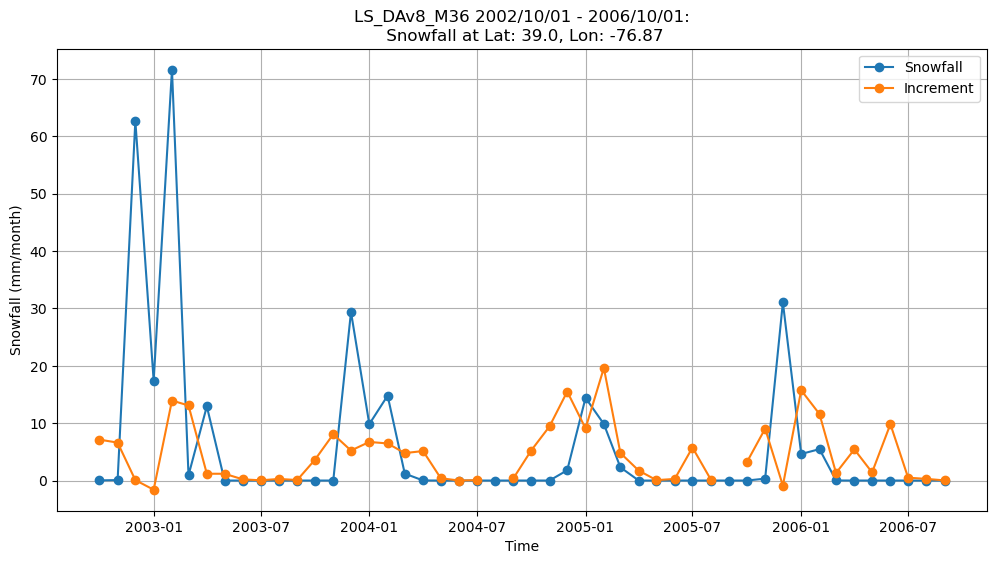

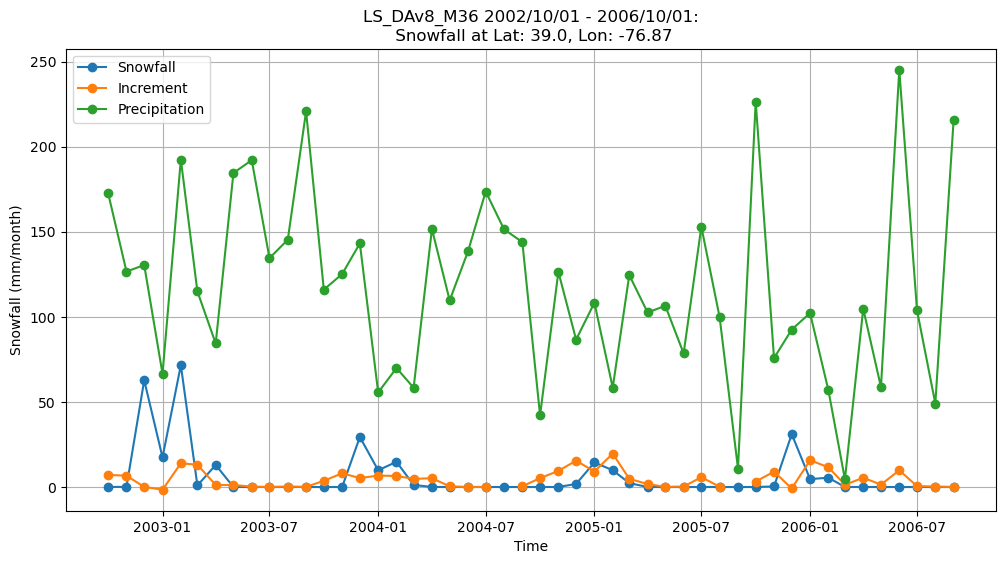

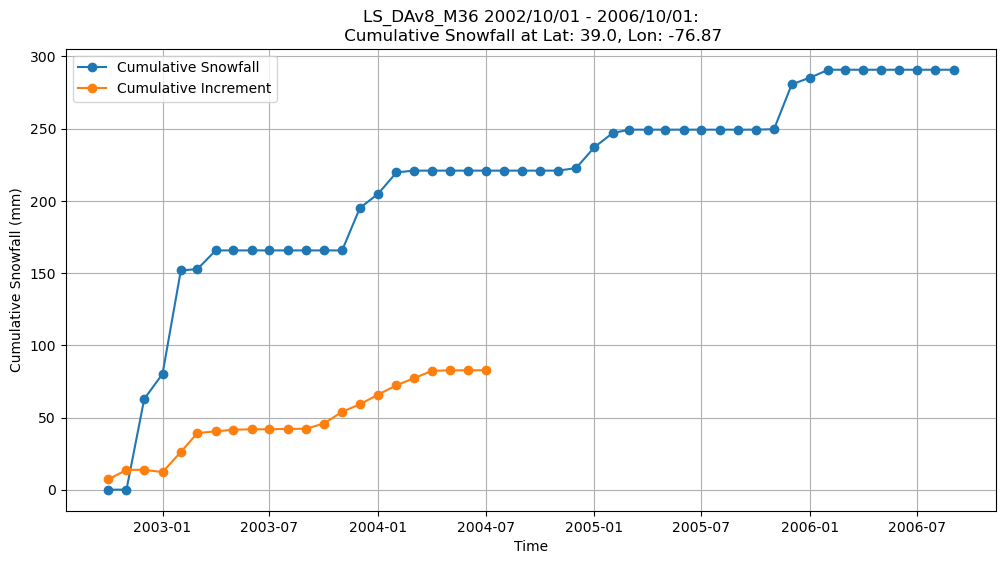

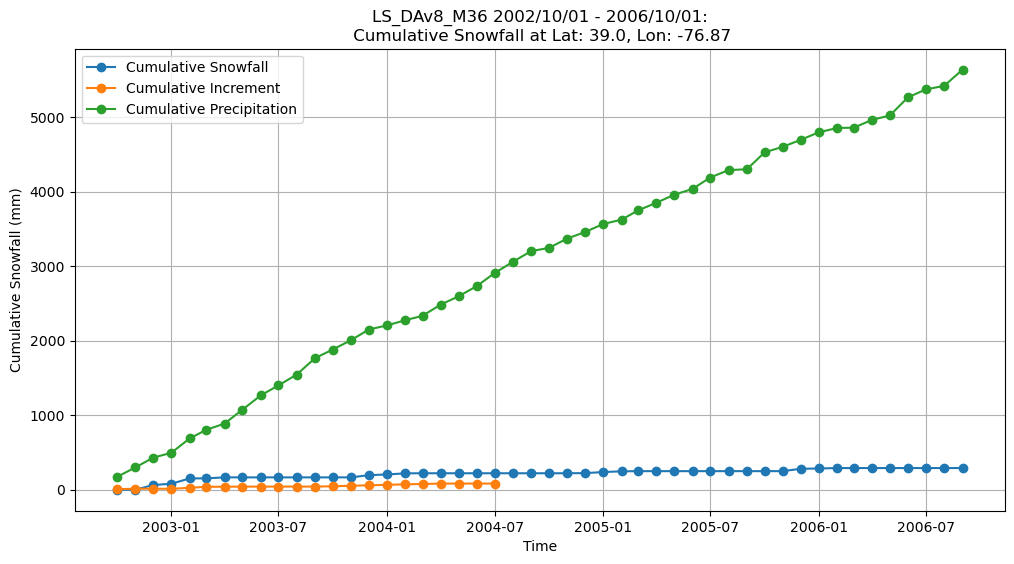

In [10]:
# Monthly time series plot of snowfall at this tile_index location
var_tile = var_data[:, tile_index]
incr_tile = total_increment[:, tile_index]
precip = ds[variables['precipitation_total_surface_flux']].values * seconds_in_month
precip = precip[:, tile_index]

# Plot the time series

plt.figure(figsize=(12, 6))
plt.plot(time_array, var_tile, marker='o')
plt.plot(time_array, incr_tile, marker='o')
plt.legend(['Snowfall', 'Increment'])
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Snowfall (mm/month)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_array, var_tile, marker='o')
plt.plot(time_array, incr_tile, marker='o')
plt.plot(time_array, precip, marker='o')
plt.legend(['Snowfall', 'Increment', 'Precipitation'])
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Snowfall (mm/month)')
plt.grid()
plt.show()

# Calculate cumulative values
cumulative_snowfall = np.cumsum(var_tile)
cumulative_increment = np.cumsum(incr_tile)
cumulative_precip = np.cumsum(precip)

# Plot the cumulative time series
plt.figure(figsize=(12, 6))
plt.plot(time_array, cumulative_snowfall, marker='o')
plt.plot(time_array, cumulative_increment, marker='o')
plt.legend(['Cumulative Snowfall', 'Cumulative Increment'])
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Cumulative Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Cumulative Snowfall (mm)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_array, cumulative_snowfall, marker='o')
plt.plot(time_array, cumulative_increment, marker='o')
plt.plot(time_array, cumulative_precip, marker='o')
plt.legend(['Cumulative Snowfall', 'Cumulative Increment', 'Cumulative Precipitation'])
plt.title(f'{expt_name} {start_date_str} - {end_date_str}:\n Cumulative Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Cumulative Snowfall (mm)')
plt.grid()
plt.show()

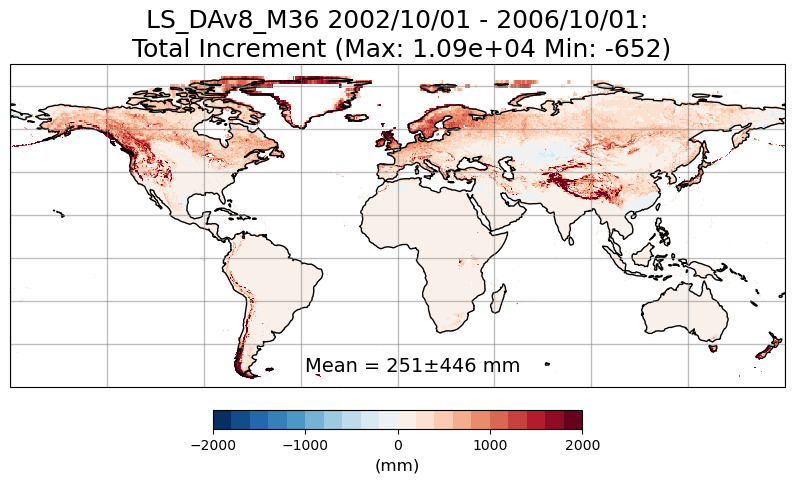

In [11]:

# Map for total increment
total_increments = np.nansum(total_increment, axis=0)

map_array[:, 0] = np.nansum(total_increment, axis=0)

maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, True, f'{expt_name} {start_date_str} - {end_date_str}:\n Total Increment (Max: {maxval:.3g} Min: {minval:.3g})', 'mm', -2000, 2000)

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/211493858.py:2: RuntimeWarning: divide by zero encountered in divide
  percent_change = (total_snowfall + total_increments) / total_snowfall
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/211493858.py:2: RuntimeWarning: invalid value encountered in divide
  percent_change = (total_snowfall + total_increments) / total_snowfall
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/211493858.py:5: RuntimeWarning: divide by zero encountered in divide
  map_array[:, 0] = total_increments / total_snowfall
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/211493858.py:5: RuntimeWarning: invalid value encountered in divide
  map_array[:, 0] = total_increments / total_snowfall
/Users/amfox/opt/anaconda3/envs/xr/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


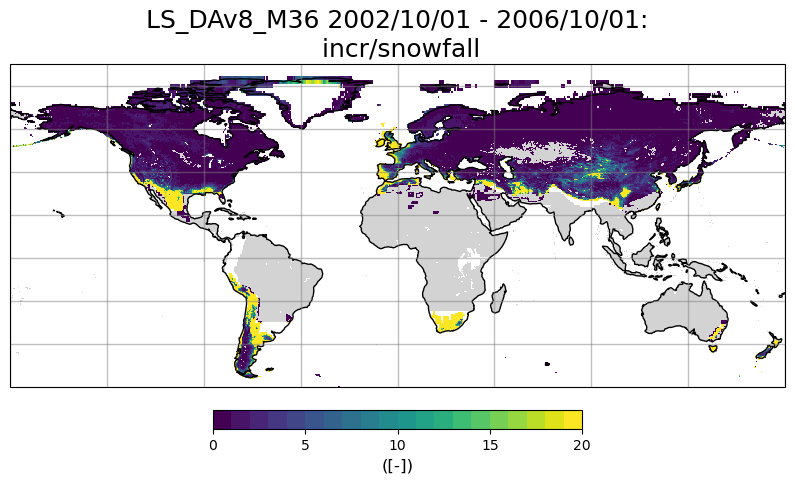

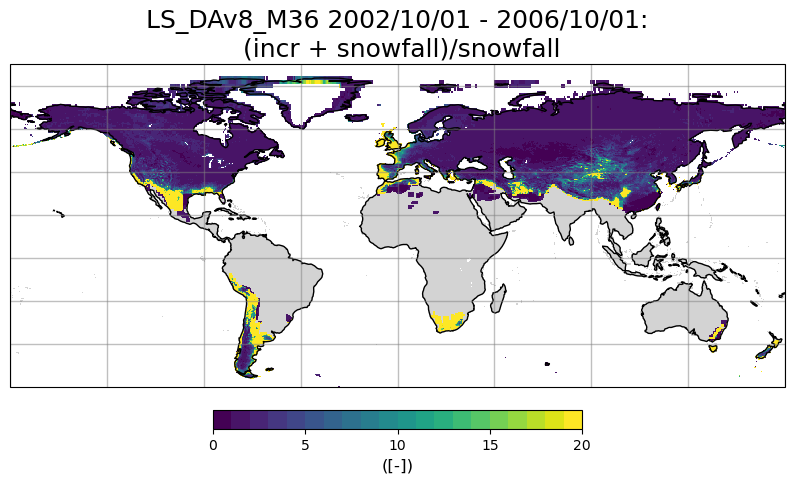

In [12]:

# Calculate % change in snowfall when you add increment
percent_change = (total_snowfall + total_increments) / total_snowfall
percent_change = np.where(np.isfinite(percent_change), percent_change, np.nan)  # Handle division by zero or NaN

map_array[:, 0] = total_increments / total_snowfall
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n incr/snowfall', '[-]', 0, 20)

# Update the map array with the percent change values
map_array[:, 0] = percent_change
# Plot the percent change
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n (incr + snowfall)/snowfall', '[-]', 0, 20)

In [13]:
expt_name = 'LS_OLv8_M36'

# Define the path directory
root_directory = f'/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/{expt_name}/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg'

# List all tavg24 files in the root directory
files = glob.glob(os.path.join(root_directory, '*tavg24_1d_lnd_Nt*.nc'))

# Filter files based on the date range
filtered_files = []
for file in files:
    # Extract the date part from the filename
    filename = os.path.basename(file)
    date_str = filename.split('.')[-2]  # Extract the date part (e.g., 200401)
    file_date = datetime.strptime(date_str, '%Y%m')

    # Check if the file date is within the range
    if start_date <= file_date < end_date:
        filtered_files.append(file)

# Load the data 
ds_ol = xr.open_mfdataset(filtered_files, combine='nested', concat_dim="time")

# Sort the dataset by the time dimension
ds_ol = ds_ol.sortby('time')

# Go back to DA experiment name for plotting etc
expt_name = 'LS_DAv8_M36'

In [14]:
ol_evap = ds_ol[variables['total_evaporation_land']].values * seconds_in_month
da_evap = ds[variables['total_evaporation_land']].values * seconds_in_month

ol_runoff = ds_ol[variables['overland_runoff_including_throughflow']].values * seconds_in_month
da_runoff = ds[variables['overland_runoff_including_throughflow']].values * seconds_in_month

ol_snowmelt = ds_ol[variables['snowmelt_flux_land']].values * seconds_in_month
da_snowmelt = ds[variables['snowmelt_flux_land']].values * seconds_in_month

ol_baseflow = ds_ol[variables['baseflow_flux_land']].values * seconds_in_month
da_baseflow = ds[variables['baseflow_flux_land']].values * seconds_in_month

ol_snowmass = ds_ol[variables['snow_mass']].values
da_snowmass = ds[variables['snow_mass']].values

ol_snowdepth = ds_ol[variables['snow_depth_within_snow_covered_area_fraction_on_land']].values
da_snowdepth = ds[variables['snow_depth_within_snow_covered_area_fraction_on_land']].values

ol_snowfall = ds_ol[variables['snowfall_land']].values * seconds_in_month
da_snowfall = ds[variables['snowfall_land']].values * seconds_in_month

ol_soil_moisture = ds_ol[variables['sm_surface']].values
da_soil_moisture = ds[variables['sm_surface']].values

ol_rzmc = ds_ol[variables['sm_rootzone']].values
da_rzmc = ds[variables['sm_rootzone']].values

ol_sm_profile = ds_ol[variables['sm_profile']].values
da_sm_profile = ds[variables['sm_profile']].values

ol_evap_sum = np.nansum(ol_evap, axis=0)
da_evap_sum = np.nansum(da_evap, axis=0)

ol_runoff_sum = np.nansum(ol_runoff, axis=0)
da_runoff_sum = np.nansum(da_runoff, axis=0)

ol_snowmelt_sum = np.nansum(ol_snowmelt, axis=0)
da_snowmelt_sum = np.nansum(da_snowmelt, axis=0)

ol_baseflow_sum = np.nansum(ol_baseflow, axis=0)
da_baseflow_sum = np.nansum(da_baseflow, axis=0)

ol_soil_moisture_mean = np.nanmean(ol_soil_moisture, axis=0)
da_soil_moisture_mean = np.nanmean(da_soil_moisture, axis=0)

ol_rzmc_mean = np.nanmean(ol_rzmc, axis=0)
da_rzmc_mean = np.nanmean(da_rzmc, axis=0)

ol_sm_profile_mean = np.nanmean(ol_sm_profile, axis=0)
da_sm_profile_mean = np.nanmean(da_sm_profile, axis=0)


/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/3006704064.py:2: RuntimeWarning: divide by zero encountered in divide
  percent_change_snowmelt = (da_snowmelt_sum - ol_snowmelt_sum) / ol_snowmelt_sum
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/3006704064.py:2: RuntimeWarning: invalid value encountered in divide
  percent_change_snowmelt = (da_snowmelt_sum - ol_snowmelt_sum) / ol_snowmelt_sum


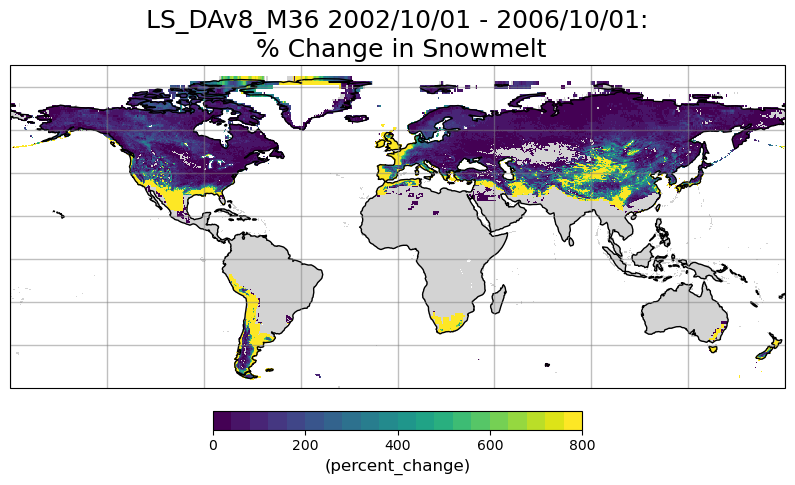

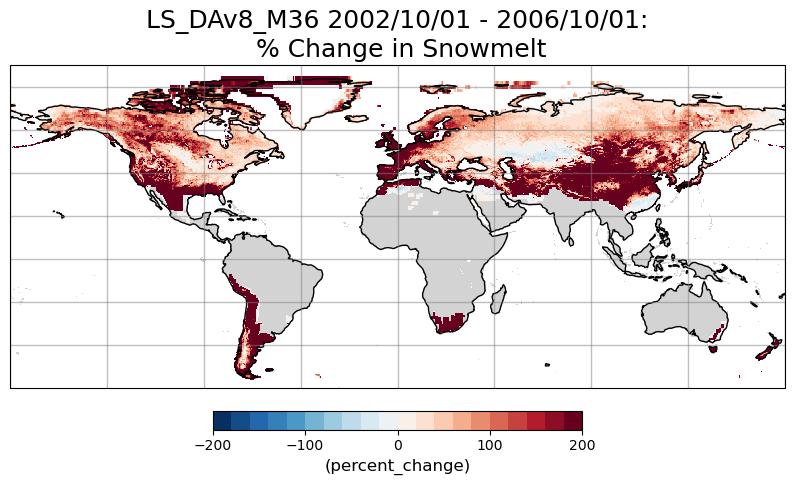

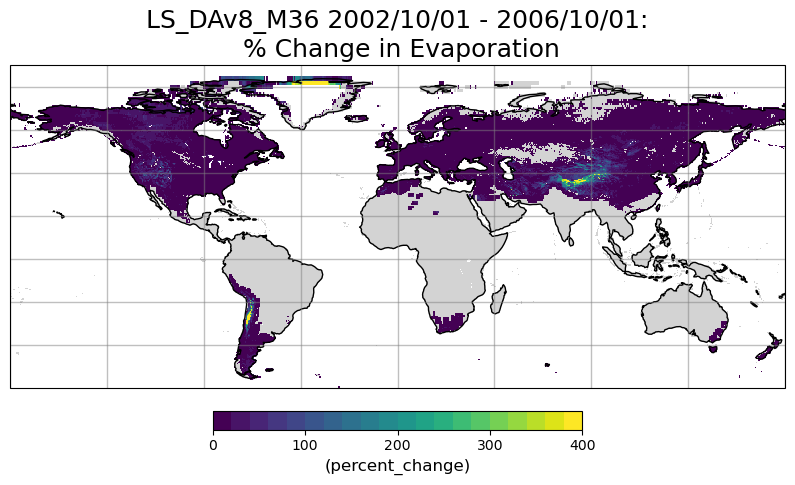

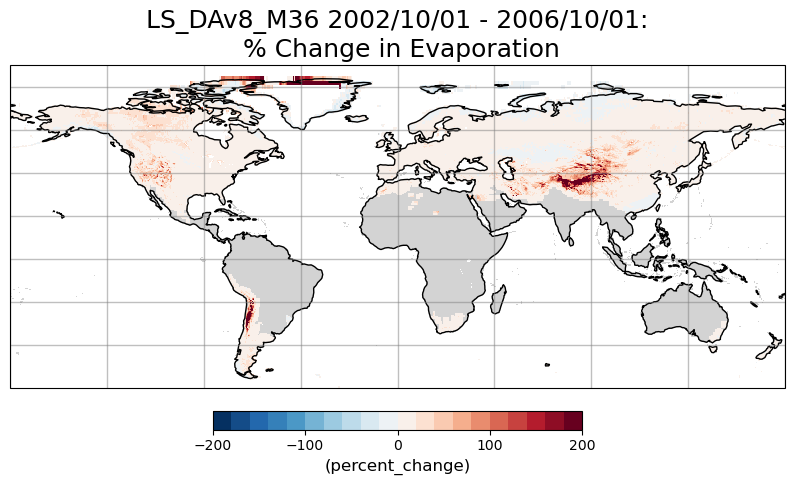

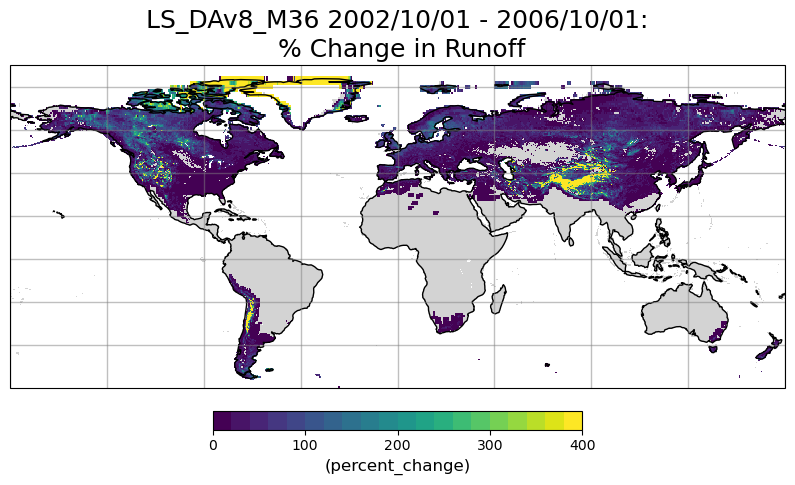

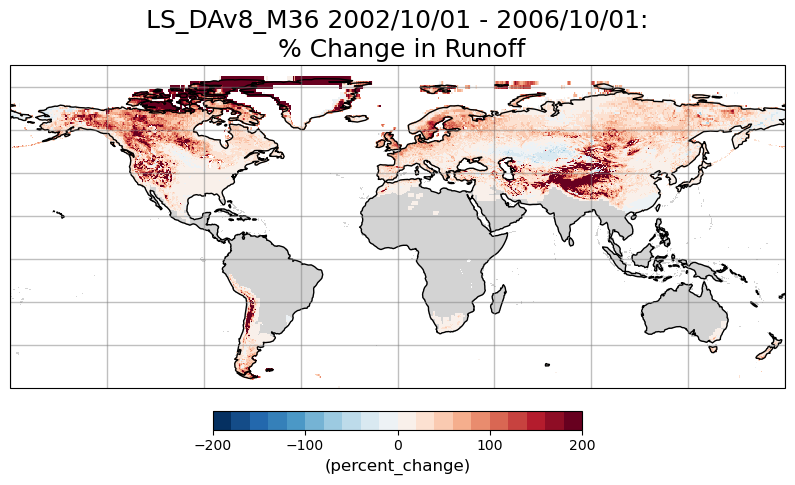

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/3006704064.py:50: RuntimeWarning: divide by zero encountered in divide
  percent_change_baseflow = (da_baseflow_sum - ol_baseflow_sum) / ol_baseflow_sum
/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/3006704064.py:50: RuntimeWarning: invalid value encountered in divide
  percent_change_baseflow = (da_baseflow_sum - ol_baseflow_sum) / ol_baseflow_sum


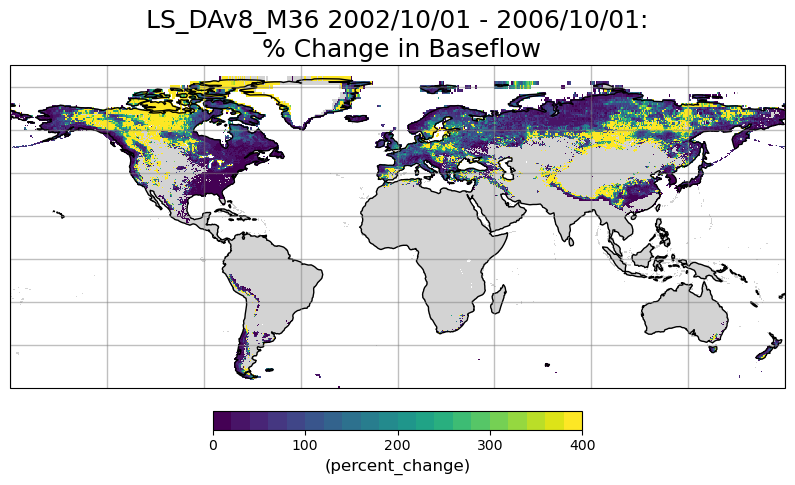

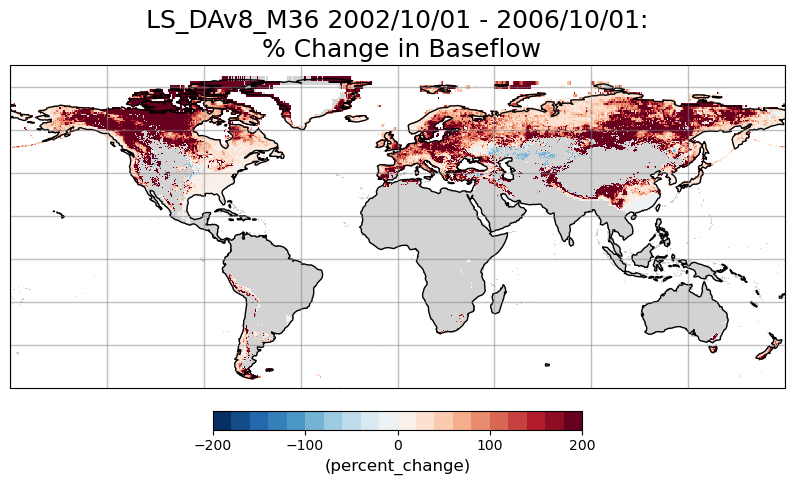

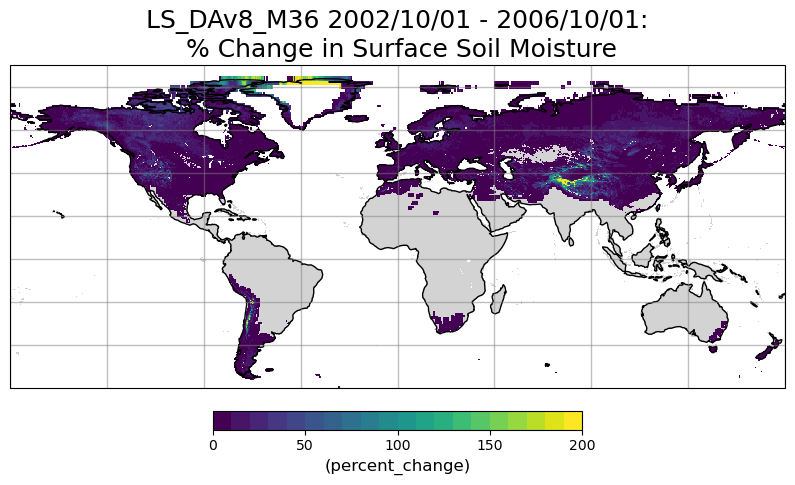

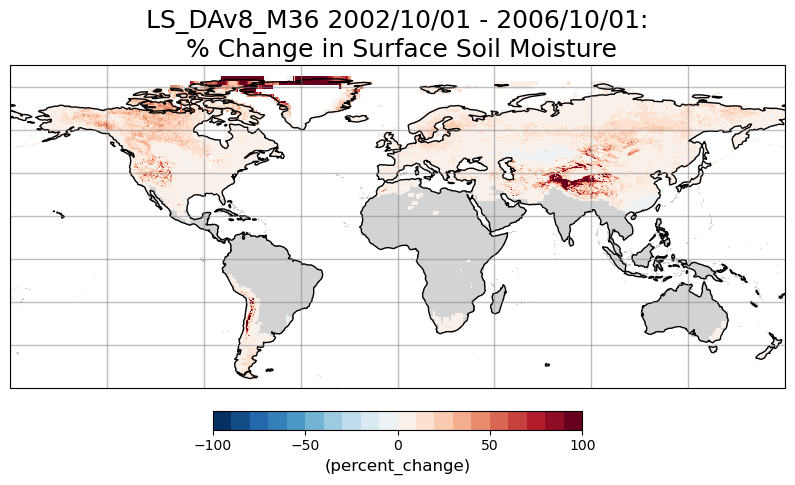

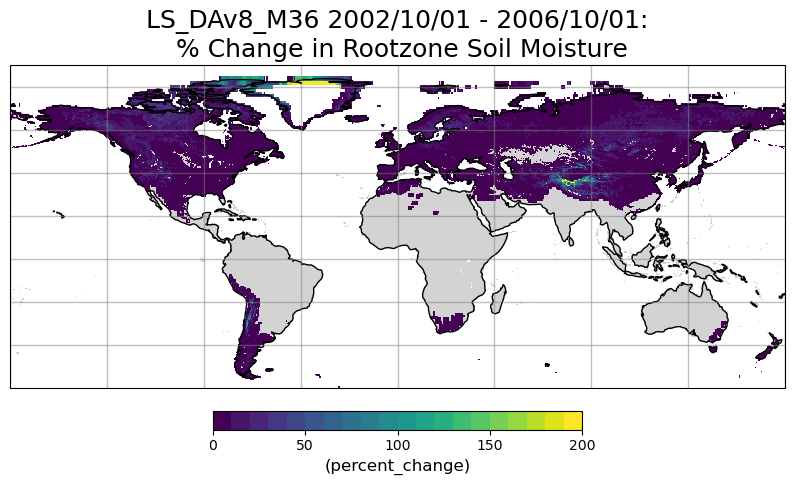

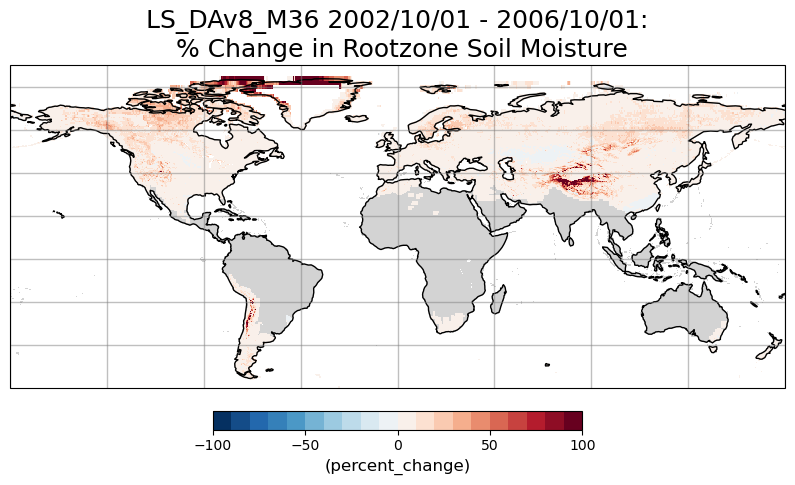

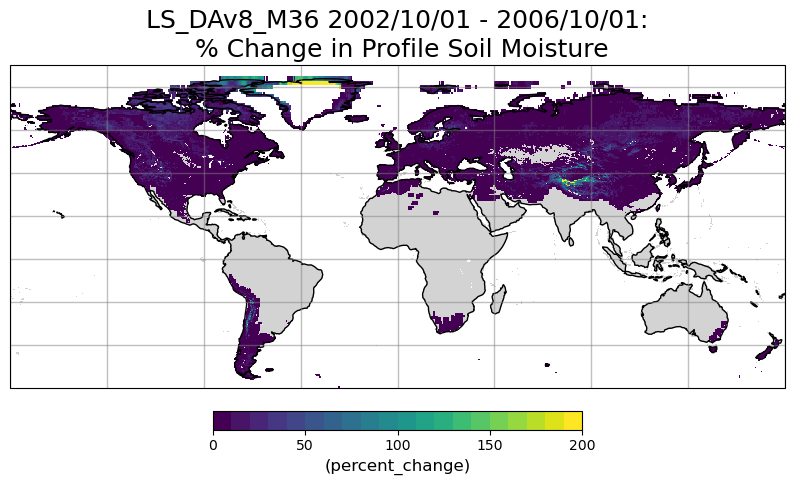

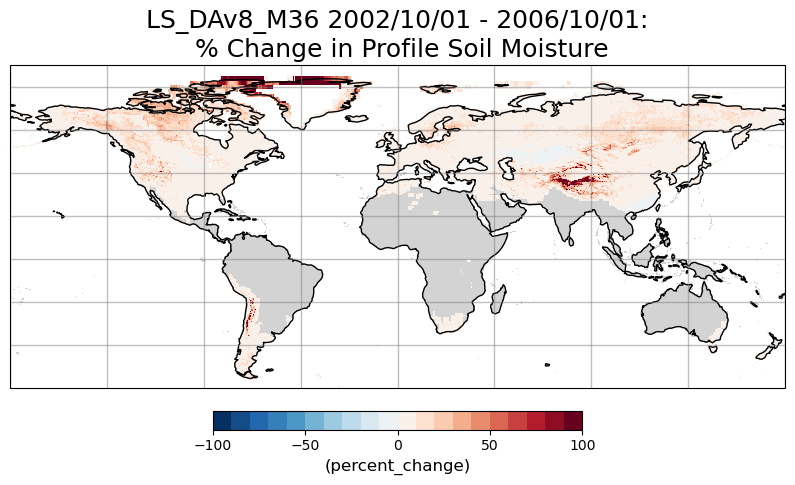

In [15]:

# Map percent change in snowmelt
percent_change_snowmelt = (da_snowmelt_sum - ol_snowmelt_sum) / ol_snowmelt_sum
percent_change_snowmelt = np.where(np.isfinite(percent_change_snowmelt), percent_change_snowmelt, np.nan)  # Handle division by zero or NaN
percent_change_snowmelt = percent_change_snowmelt * 100

# Create a mask where percent_change_snowmelt is NaN
nan_mask = np.isnan(percent_change_snowmelt)

# Update the map array with the percent change values
map_array[:, 0] = percent_change_snowmelt

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Snowmelt', 'percent_change', 0, 800)
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Snowmelt', 'percent_change', -200, 200)

# Map percent change in evaporation
percent_change_evap = (da_evap_sum - ol_evap_sum) / ol_evap_sum
percent_change_evap = np.where(np.isfinite(percent_change_evap), percent_change_evap, np.nan)  # Handle division by zero or NaN
percent_change_evap = percent_change_evap * 100
# Apply the NaN mask to percent_change_evap
percent_change_evap[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_evap

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Evaporation', 'percent_change', 0, 400)
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Evaporation', 'percent_change', -200, 200)

# Map percent change in runoff
percent_change_runoff = (da_runoff_sum - ol_runoff_sum) / ol_runoff_sum
percent_change_runoff = np.where(np.isfinite(percent_change_runoff), percent_change_runoff, np.nan)  # Handle division by zero or NaN
percent_change_runoff = percent_change_runoff * 100
percent_change_runoff[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_runoff

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Runoff', 'percent_change', 0, 400)
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Runoff', 'percent_change', -200, 200)

# Map percent change in baseflow
percent_change_baseflow = (da_baseflow_sum - ol_baseflow_sum) / ol_baseflow_sum
percent_change_baseflow = np.where(np.isfinite(percent_change_baseflow), percent_change_baseflow, np.nan)  # Handle division by zero or NaN
percent_change_baseflow = percent_change_baseflow * 100
percent_change_baseflow[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_baseflow

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Baseflow', 'percent_change', 0, 400)
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Baseflow', 'percent_change', -200, 200)

# Map percent change in soil moisture
percent_change_soil_moisture = (da_soil_moisture_mean - ol_soil_moisture_mean) / ol_soil_moisture_mean
percent_change_soil_moisture = np.where(np.isfinite(percent_change_soil_moisture), percent_change_soil_moisture, np.nan)  # Handle division by zero or NaN
percent_change_soil_moisture = percent_change_soil_moisture * 100
percent_change_soil_moisture[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_soil_moisture

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Surface Soil Moisture', 'percent_change', 0, 200)
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Surface Soil Moisture', 'percent_change', -100, 100)

# Map percent change in rootzone soil moisture
percent_change_rzmc = (da_rzmc_mean - ol_rzmc_mean) / ol_rzmc_mean
percent_change_rzmc = np.where(np.isfinite(percent_change_rzmc), percent_change_rzmc, np.nan)  # Handle division by zero or NaN
percent_change_rzmc = percent_change_rzmc * 100
percent_change_rzmc[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_rzmc

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Rootzone Soil Moisture', 'percent_change', 0, 200)
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Rootzone Soil Moisture', 'percent_change', -100, 100)

# Map percent change in profile soil moisture
percent_change_sm_profile = (da_sm_profile_mean - ol_sm_profile_mean) / ol_sm_profile_mean
percent_change_sm_profile = np.where(np.isfinite(percent_change_sm_profile), percent_change_sm_profile, np.nan)  # Handle division by zero or NaN
percent_change_sm_profile = percent_change_sm_profile * 100
percent_change_sm_profile[nan_mask] = np.nan

# Update the map array with the percent change values
map_array[:, 0] = percent_change_sm_profile

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Profile Soil Moisture', 'percent_change', 0, 200)
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n % Change in Profile Soil Moisture', 'percent_change', -100, 100)

In [16]:
# Load all the concatenated observations
data = np.load(f'../test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/LS_DAv8_M36_20050101_20060101_obsfcstana_extend_datetime_2005.npz', allow_pickle=True)

# List of all the variables in the file
data.files

['date_time',
 'obs_species',
 'obs_tilenum',
 'obs_lon',
 'obs_lat',
 'obs_obs',
 'obs_fcst',
 'obs_ana']

In [17]:
#lon_value = -105.25 #-76.875 #-76.87 # -105.25 # 84.0
#lat_value = 40.01 # 39.0 #39.0 # 40.01 # 31.0

# find the index of the tile closest to the given lat/lon
#tile_index = np.argmin((lat.values - lat_value)**2 + (lon.values - lon_value)**2)
#print(tile_index)

In [18]:
ts_ts = data['date_time'][data['obs_tilenum'] == tile_index+1]
ts_obs = data['obs_obs'][data['obs_tilenum'] == tile_index+1]
ts_fcst = data['obs_fcst'][data['obs_tilenum'] == tile_index+1]
ts_ana = data['obs_ana'][data['obs_tilenum'] == tile_index+1]

print(ts_ts[1])

# Parse time information and create datetime objects
dates = []
for entry in ts_ts:
    year = entry['year'][0]
    month = entry['month'][0]
    day = entry['day'][0]
    hour = entry['hour'][0]
    minute = entry['min'][0]
    second = entry['sec'][0]
    dates.append(datetime(year, month, day, hour, minute, second))

# Sort dates, ts_obs, ts_fcst, ts_ana by date
dates, ts_obs, ts_fcst, ts_ana = zip(*sorted(zip(dates, ts_obs, ts_fcst, ts_ana)))

# Ensure ts_ana and ts_fcst are numerical arrays
ts_obs = np.array(ts_obs)
ts_ana = np.array(ts_ana)
ts_fcst = np.array(ts_fcst)

{'year': array([2005], dtype=int32), 'month': array([1], dtype=int32), 'day': array([7], dtype=int32), 'hour': array([18], dtype=int32), 'min': array([0], dtype=int32), 'sec': array([0], dtype=int32), 'dofyr': array([7], dtype=int32), 'pentad': array([2], dtype=int32)}


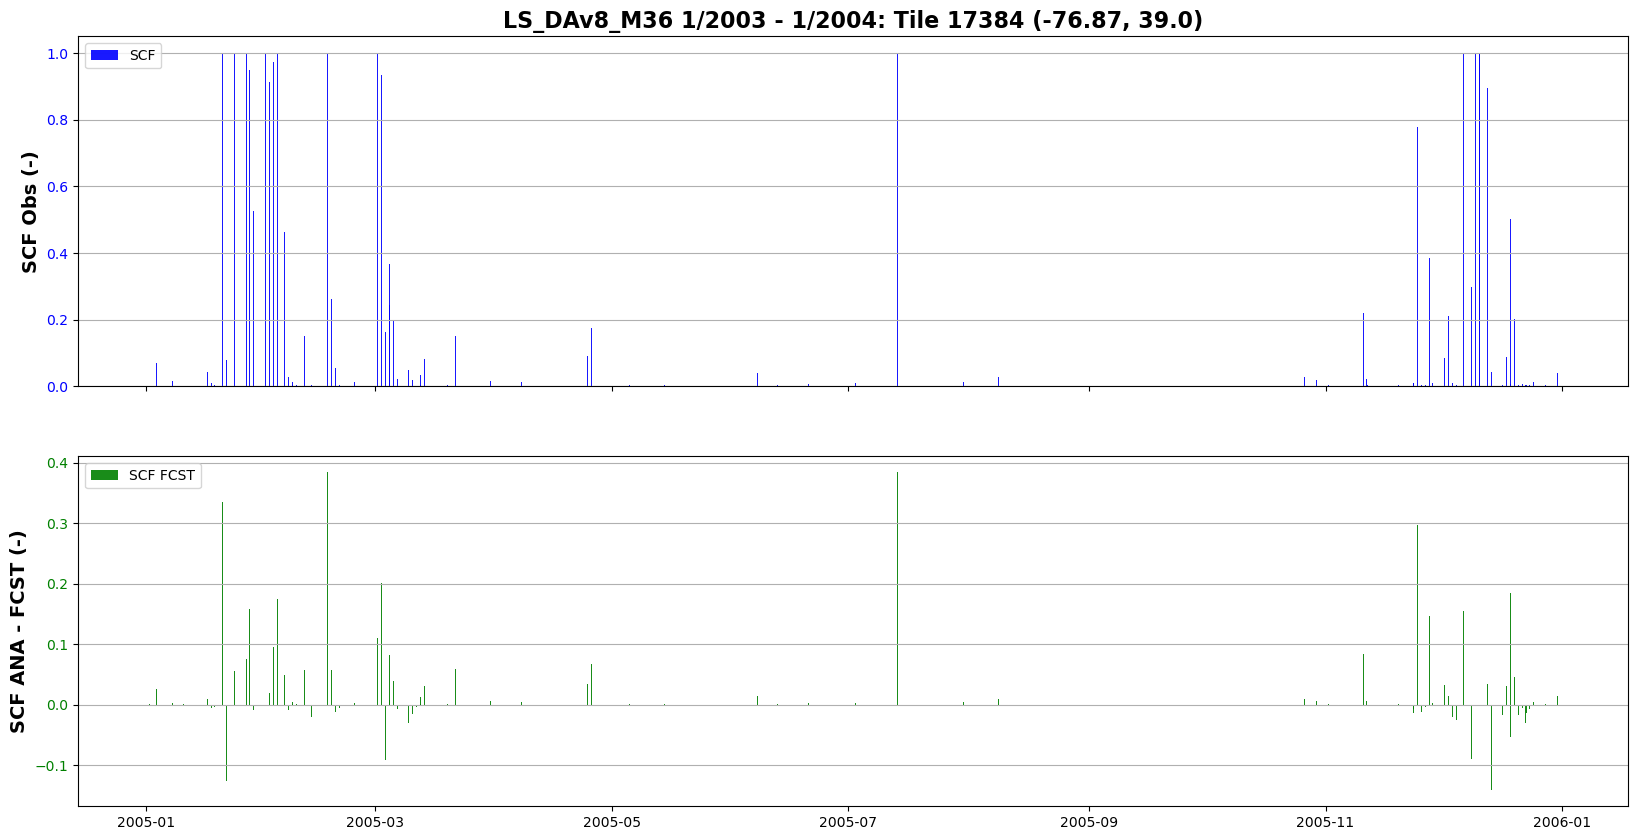

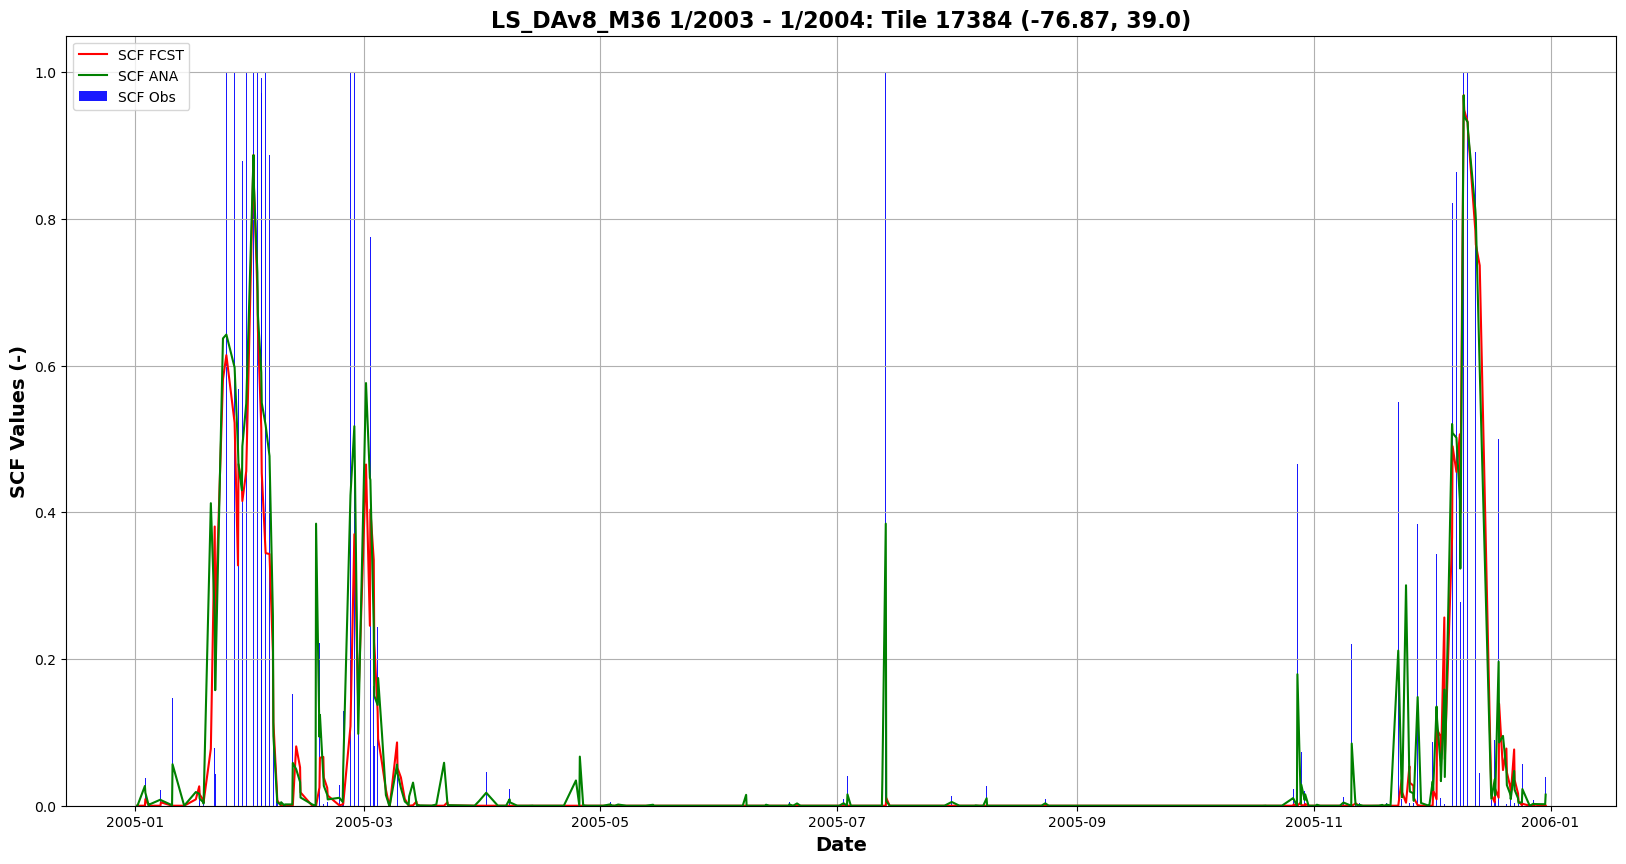

In [19]:
bar_width = 0.15
opacity = 0.9

# Plot obs_inc_s in the top subplot with two y-axes
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)
ax1.bar(dates, ts_obs, bar_width, alpha=opacity, color='blue', label='SCF')
ax1.set_ylabel('SCF Obs (-)', weight='bold', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title(f'{expt_name} 1/2003 - 1/2004: Tile {tile_index} ({lon_value}, {lat_value})', weight='bold', fontsize=16)
ax1.grid(axis='y')
ax1.legend(loc='upper left')

ax2.bar(dates, ts_ana - ts_fcst, bar_width, alpha=opacity, color='green', label='SCF FCST')
#ax2.bar(dates, ts_ana, bar_width, alpha=opacity, color='red', label='SCF ANA')
ax2.set_ylabel('SCF ANA - FCST (-)', weight='bold', fontsize=14)
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(axis='y')
ax2.legend(loc='upper left')

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(dates, ts_obs, bar_width, alpha=opacity, label='SCF Obs', color='blue')
ax.plot(dates, ts_fcst, label='SCF FCST', color='red')
ax.plot(dates, ts_ana, label='SCF ANA', color='green')

ax.set_xlabel('Date', weight='bold', fontsize=14)
ax.set_ylabel('SCF Values (-)', weight='bold', fontsize=14)
ax.set_title(f'{expt_name} 1/2003 - 1/2004: Tile {tile_index} ({lon_value}, {lat_value})', weight='bold', fontsize=16)
ax.legend(loc='upper left')
ax.grid(True)

plt.show()

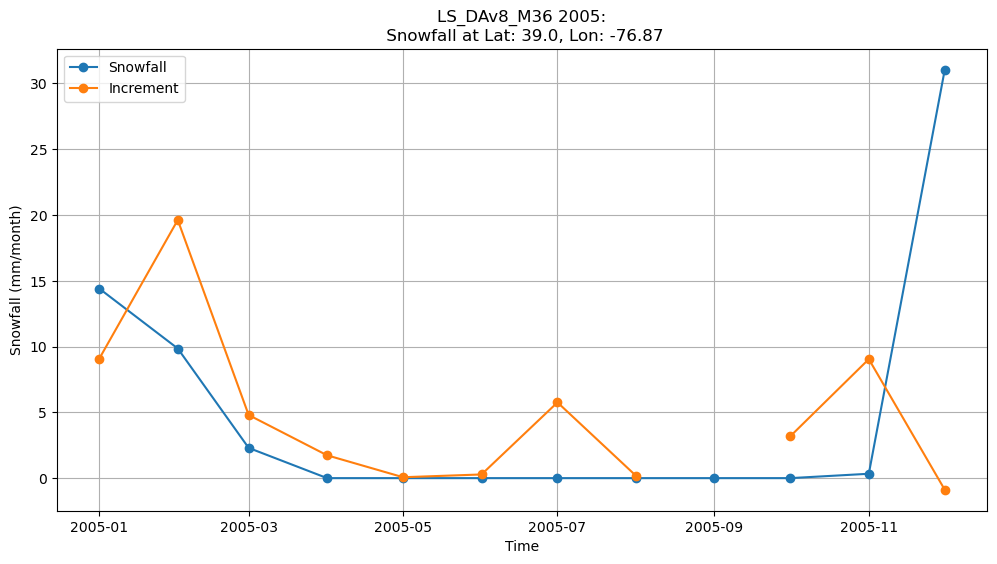

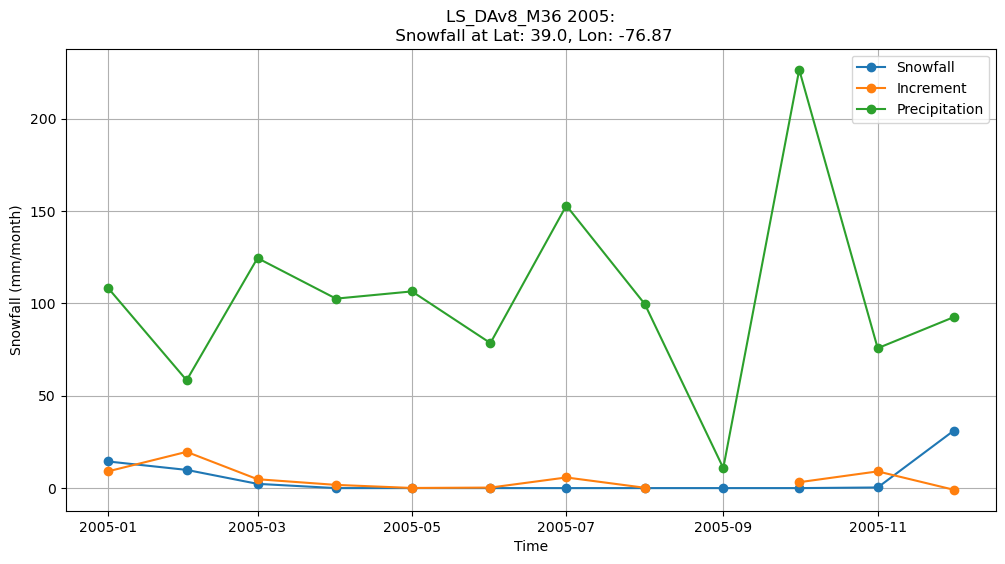

<Figure size 1200x600 with 0 Axes>

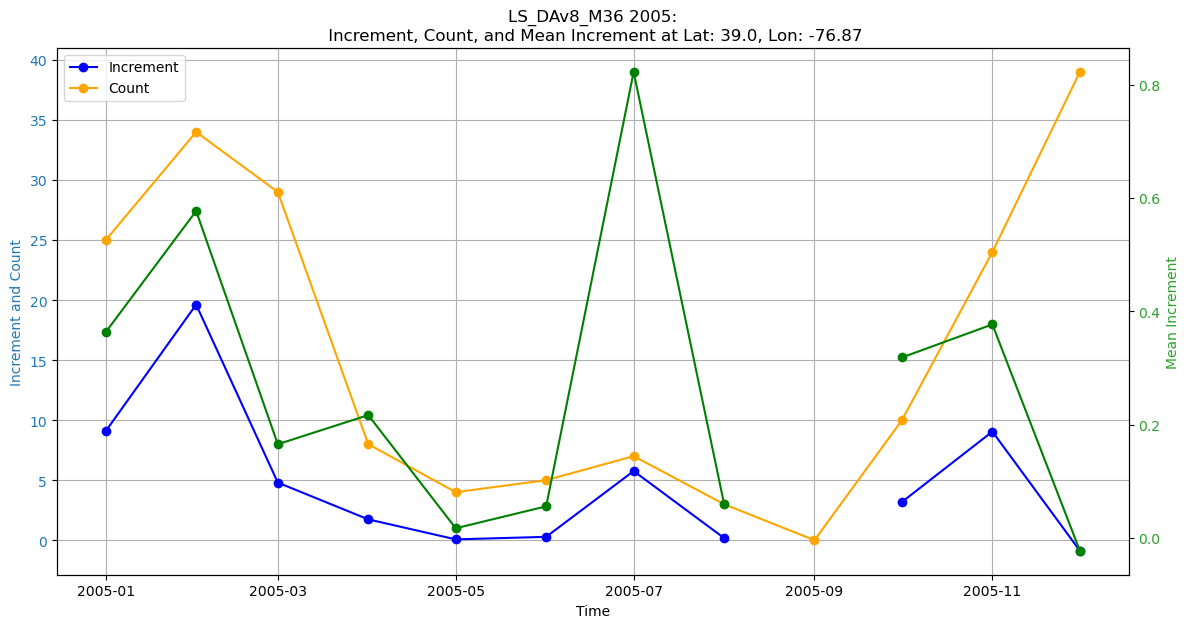

In [20]:
#lon_value = -105.25 # -110.978 # -76.87 # -105.25 # 84.0
#lat_value = 40.01 # 32.25 # 39.0 # 40.01 # 31.0

# find the index of the tile closest to the given lat/lon
#tile_index = np.argmin((lat.values - lat_value)**2 + (lon.values - lon_value)**2)
#print(tile_index)

# Monthly time series plot of snowfall at this tile_index location
# Extract and plot total snowfall over the experiement period
var = variables["snowfall_land"]

# Extract the variable
var_data = ds[var].values

# Convert the units from kg/m2/sec to mm/month using seconds_in_month
var_data = var_data * seconds_in_month

var_tile = var_data[:, tile_index]
incr_tile = total_increment[:, tile_index]
n_incr_tile = snow_incr_count[:, tile_index] 
mean_incr_tile = snow_incr_mean[:, tile_index]
precip = ds[variables['precipitation_total_surface_flux']].values * seconds_in_month
precip = precip[:, tile_index]

# Restrict data to the year 2005
mask_2005 = np.array([t.year == 2005 for t in time_array])
time_array_2005 = time_array[mask_2005]
var_tile_2005 = var_tile[mask_2005]
incr_tile_2005 = incr_tile[mask_2005]
n_incr_tile_2005 = n_incr_tile[mask_2005]
mean_incr_tile_2005 = mean_incr_tile[mask_2005]
precip_2005 = precip[mask_2005]

# Plot the time series for 2005
plt.figure(figsize=(12, 6))
plt.plot(time_array_2005, var_tile_2005, marker='o')
plt.plot(time_array_2005, incr_tile_2005, marker='o')
plt.legend(['Snowfall', 'Increment'])
plt.title(f'{expt_name} 2005:\n Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Snowfall (mm/month)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_array_2005, var_tile_2005, marker='o')
plt.plot(time_array_2005, incr_tile_2005, marker='o')
plt.plot(time_array_2005, precip_2005, marker='o')
plt.legend(['Snowfall', 'Increment', 'Precipitation'])
plt.title(f'{expt_name} 2005:\n Snowfall at Lat: {lat_value}, Lon: {lon_value}')
plt.xlabel('Time')
plt.ylabel('Snowfall (mm/month)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
fig, ax1 = plt.subplots(figsize=(12, 6))

# First y-axis
color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Increment and Count', color=color)
ax1.plot(time_array_2005, incr_tile_2005, marker='o', color='blue', label='Increment')
ax1.plot(time_array_2005, n_incr_tile_2005, marker='o', color='orange', label='Count')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid()

# Second y-axis
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Mean Increment', color=color)
ax2.plot(time_array_2005, mean_incr_tile_2005, marker='o', color='green', label='Mean Increment')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'{expt_name} 2005:\n Increment, Count, and Mean Increment at Lat: {lat_value}, Lon: {lon_value}')
plt.show()

In [21]:
print(snow_incr_count.shape)
print(time_array[33])
print(tile_index)

(48, 112573)
2005-07-01
17384


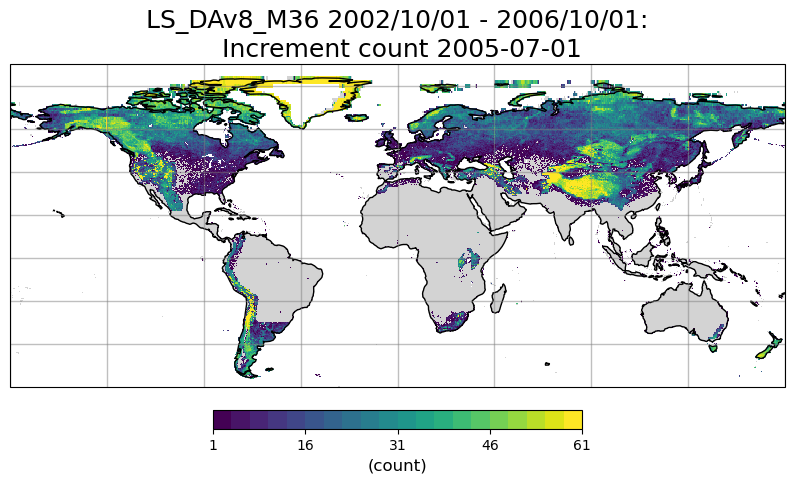

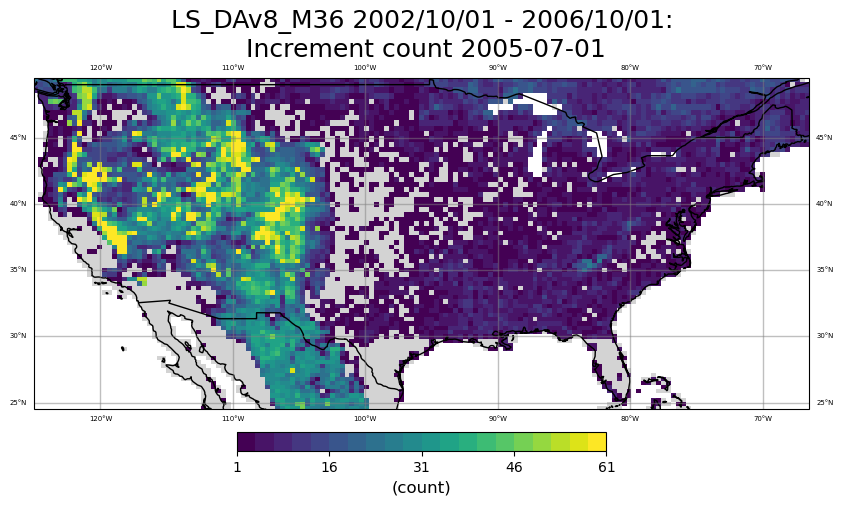

In [22]:
map_array[:, 0] = snow_incr_count[33, :]

# Plot the percent change
maxval = np.nanmax(map_array[:, 0])
minval = np.nanmin(map_array[:, 0])
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Increment count {time_array[33]}', 'count', 1, 61)

plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Increment count {time_array[33]}', 'count', 1, 61)


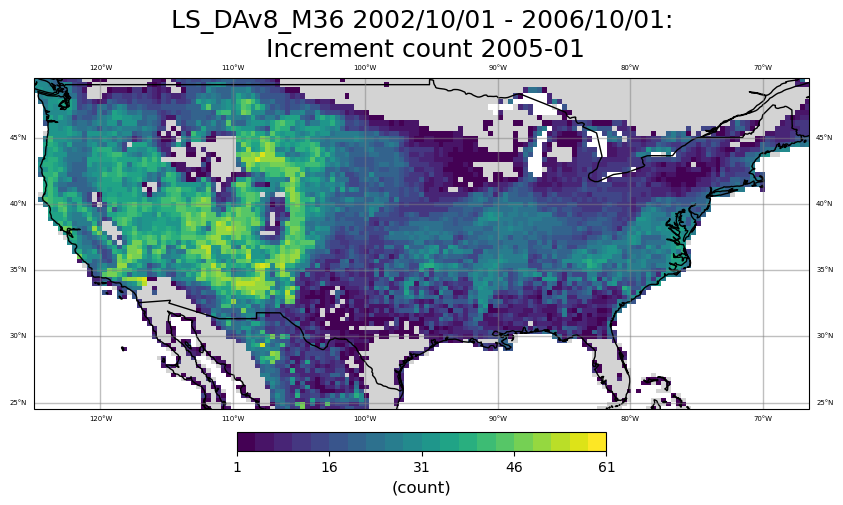

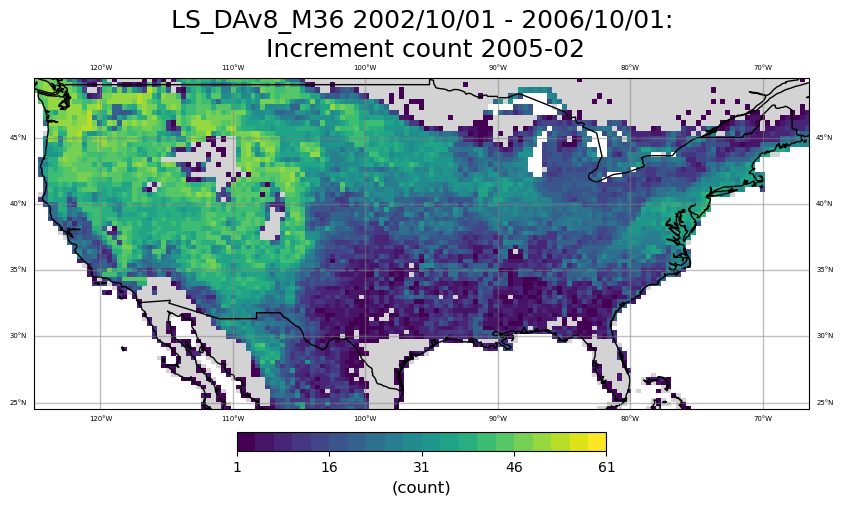

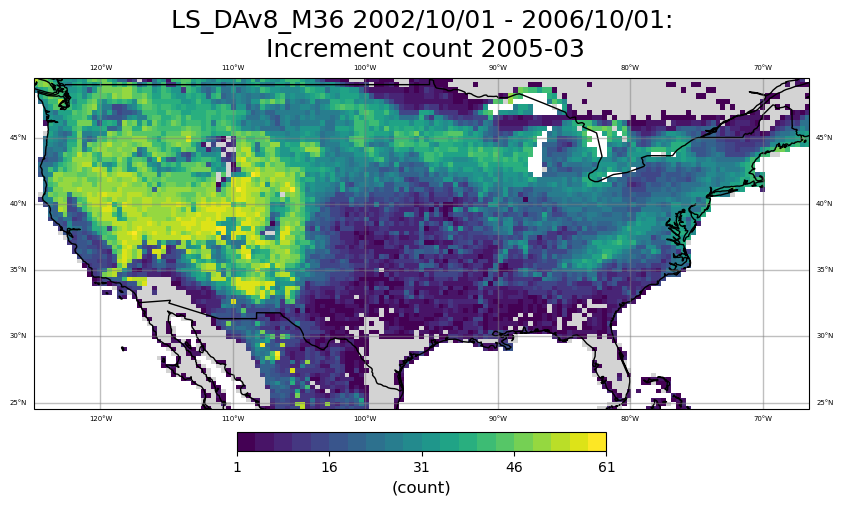

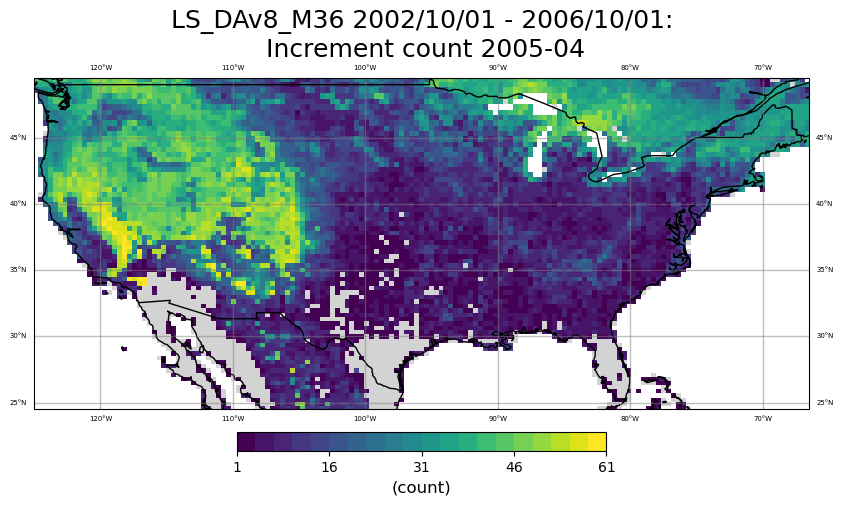

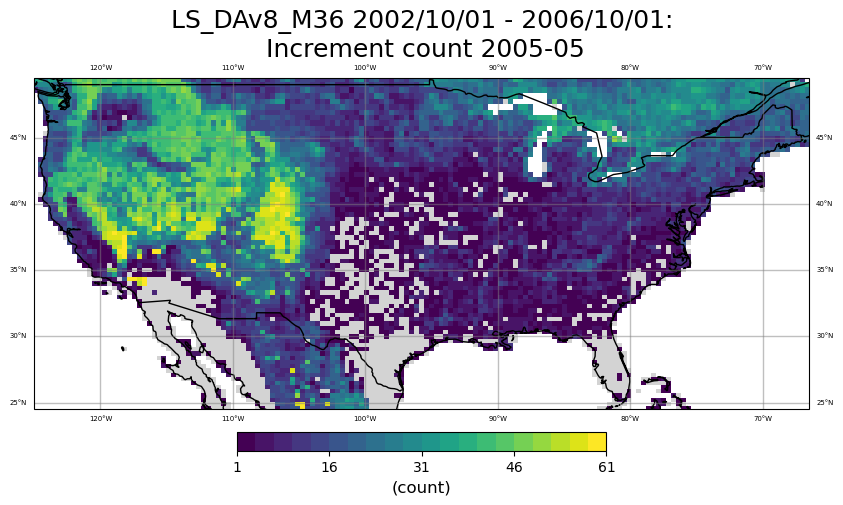

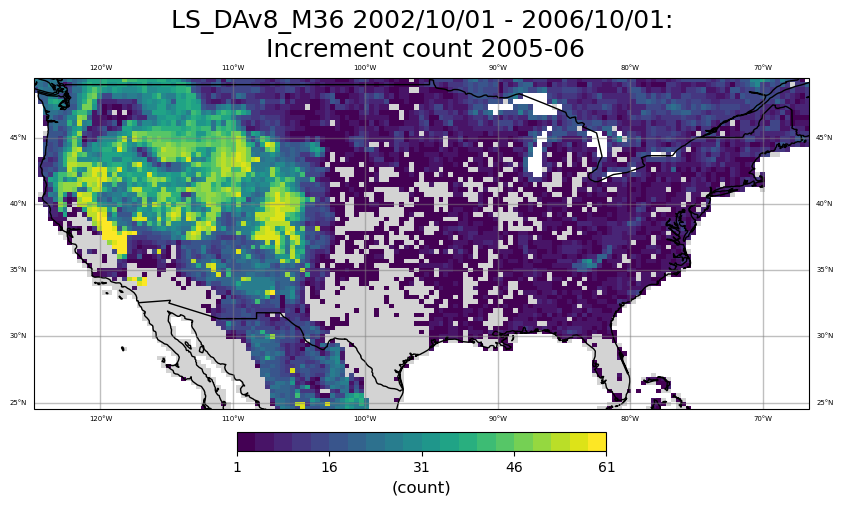

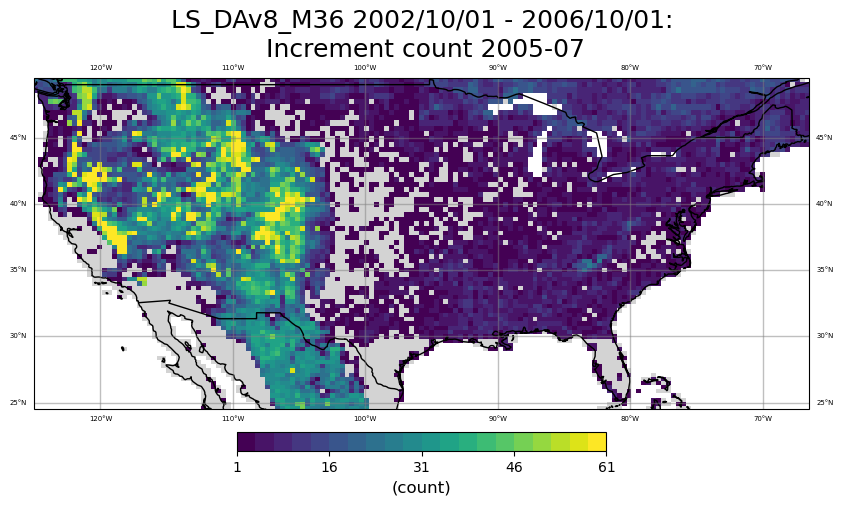

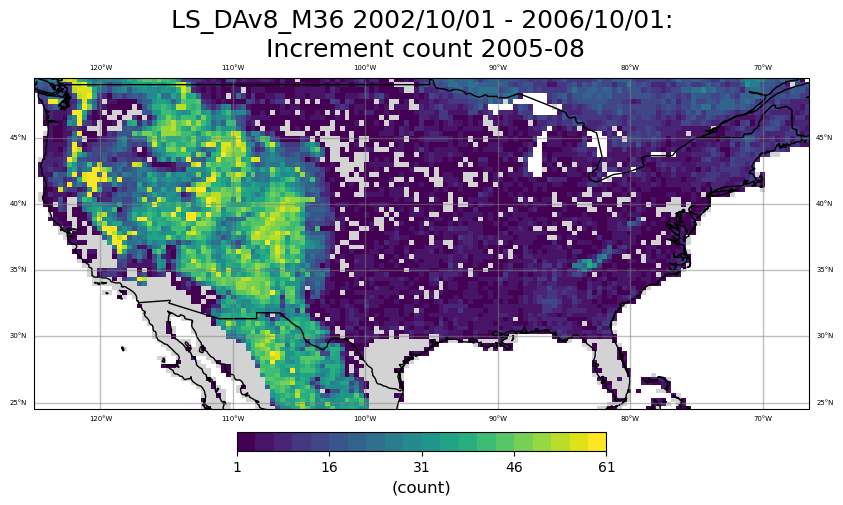

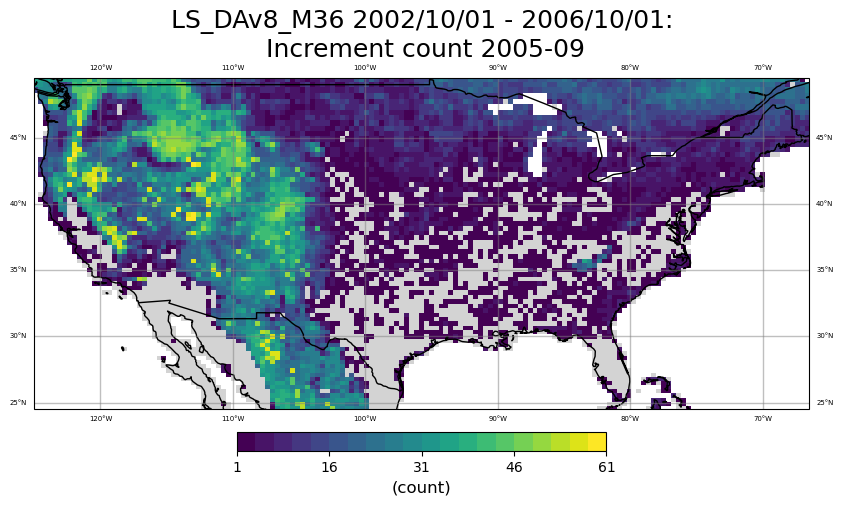

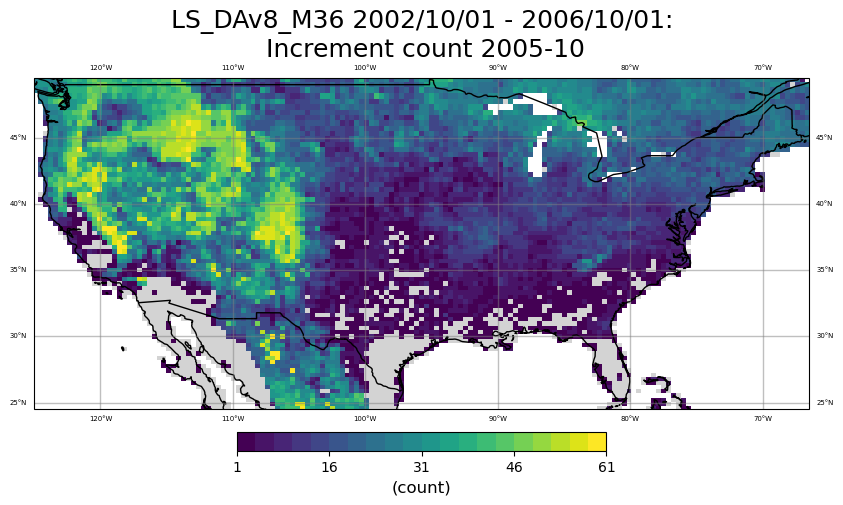

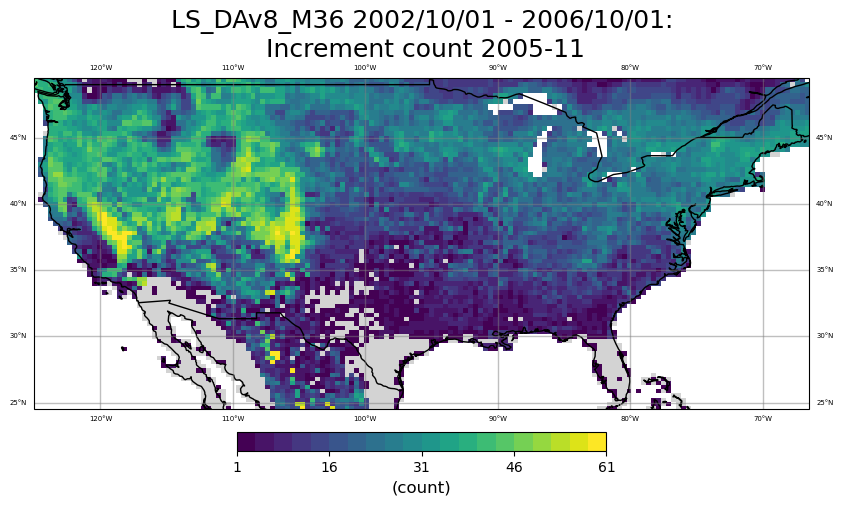

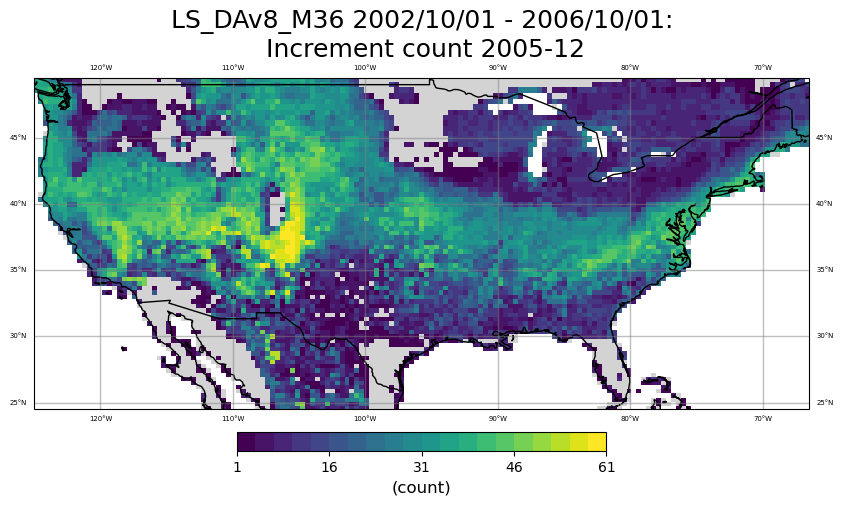

In [23]:
for month_index in range(27, 39): 
    map_array[:, 0] = snow_incr_count[month_index, :]
    plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Increment count {time_array[month_index].strftime("%Y-%m")}', 'count', 1, 61)


24
0.37700185


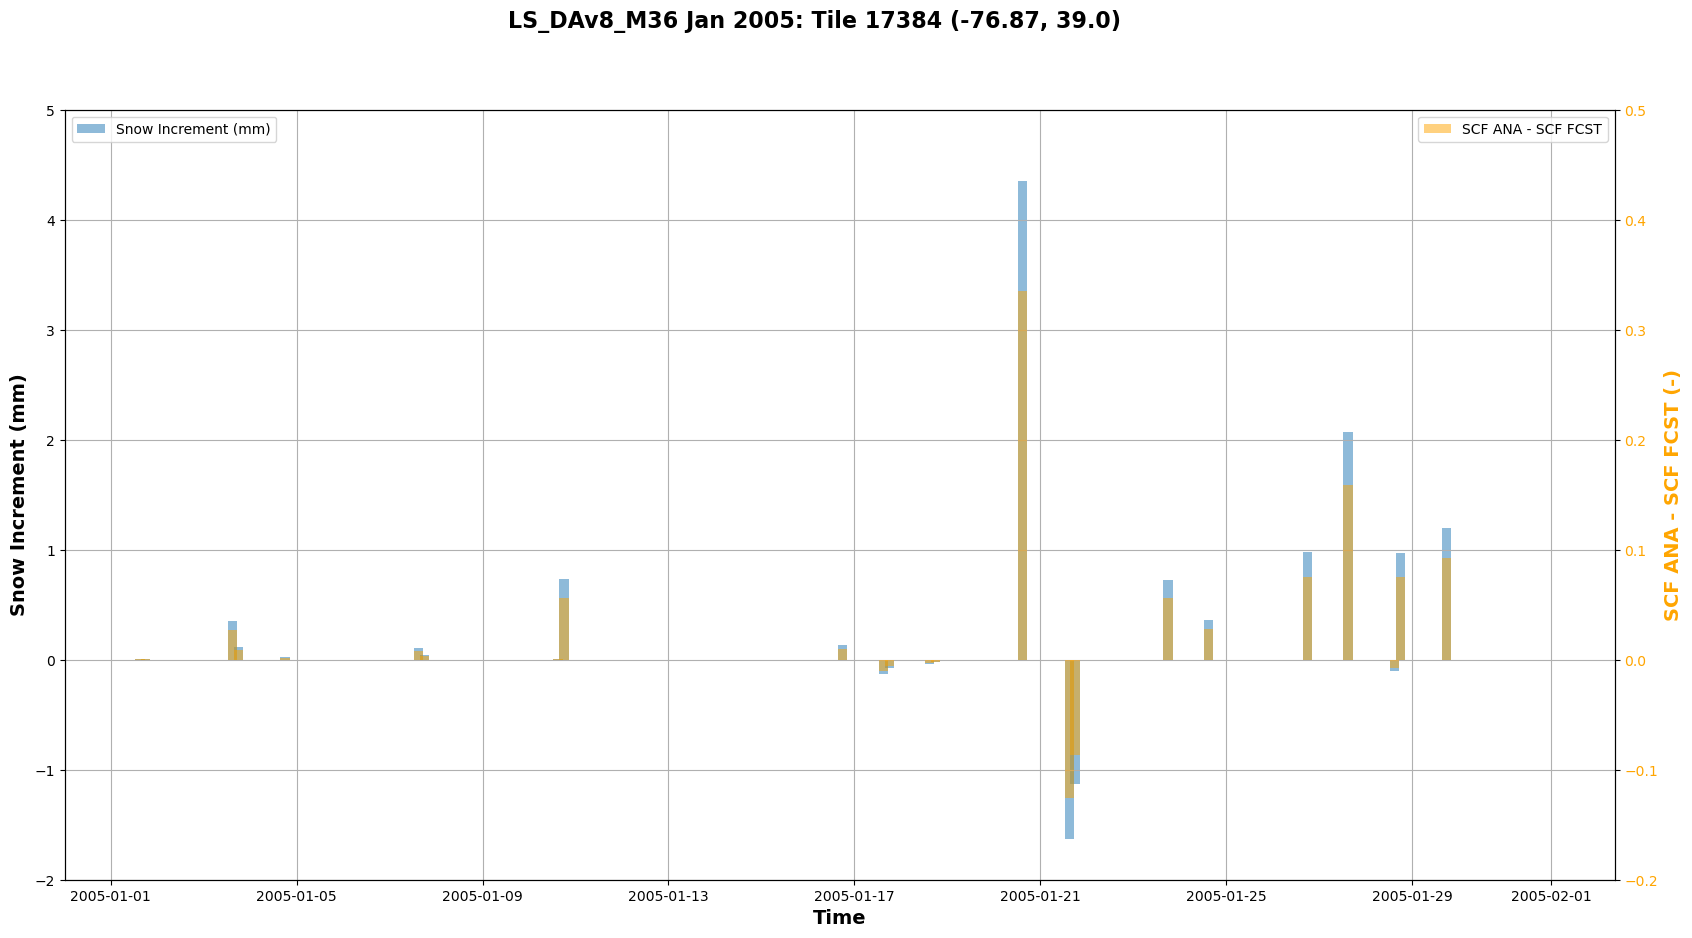

In [24]:
year_month_directory = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg/Y2005/M01'

# Find the files
files = glob.glob(f"{year_month_directory}/*catch_progn_incr*.nc4")

# Load the data
data = xr.open_mfdataset(files, combine='nested', concat_dim="time")

time = data['time'].values
time_stamp = data['time_stamp']
wesnn1_incr = data['WESNN1_INCR']
wesnn2_incr = data['WESNN2_INCR']
wesnn3_incr = data['WESNN3_INCR']

snow_incr = wesnn1_incr + wesnn2_incr + wesnn3_incr
# Ensure snow_incr is properly defined
if not isinstance(snow_incr, xr.DataArray):
    raise ValueError("snow_incr is not a valid xarray.DataArray")

# Find snow increments that are larger than abs(0.001)
snow_incr = snow_incr.where(np.abs(snow_incr) > 0.001)

# Count and find the mean of the snow increments, ignoring NaNs
snow_incr_count = snow_incr.count(dim='time')
snow_incr_mean = snow_incr.mean(dim='time', skipna=True)  
print(snow_incr_count.values[tile_index])
print(snow_incr_mean.values[tile_index])

time_stamp_values = time_stamp.values

# Parse the byte strings into datetime objects
parsed_timestamps = [
    datetime.strptime(ts.decode('utf-8').rstrip('z'), '%Y%m%d_%H%M') for ts in time_stamp_values
]

# Filter data for January 2005
jan_2005_mask = [date.year == 2005 and date.month == 1 for date in dates]
dates_jan_2005 = np.array(dates)[jan_2005_mask]
ts_obs_jan_2005 = ts_obs[jan_2005_mask]
ts_fcst_jan_2005 = ts_fcst[jan_2005_mask]
ts_ana_jan_2005 = ts_ana[jan_2005_mask]

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot snow_incr on the primary y-axis (bars)
ax1.bar(parsed_timestamps, snow_incr[:, tile_index], width=0.2, alpha=0.5, label='Snow Increment (mm)')
ax1.set_xlabel('Time', weight='bold', fontsize=14)
ax1.set_ylabel('Snow Increment (mm)', weight='bold', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_ylim(-2, 5)  # Set y-axis limits for snow increment
ax1.grid(True)

# Create a secondary y-axis for ts_ana_jan_2005 - ts_fcst_jan_2005
ax2 = ax1.twinx()
ts_diff = ts_ana_jan_2005 - ts_fcst_jan_2005  # Compute the difference
ax2.bar(dates_jan_2005, ts_diff, label='SCF ANA - SCF FCST', width=0.2, alpha=0.5, color='orange')
ax2.set_ylabel('SCF ANA - SCF FCST (-)', weight='bold', fontsize=14, color='orange')
ax2.set_ylim(-0.2, 0.5)  # Set y-axis limits for SCF difference
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and legend
fig.suptitle(f'{expt_name} Jan 2005: Tile {tile_index} ({lon_value}, {lat_value})', weight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

6
0.95583457


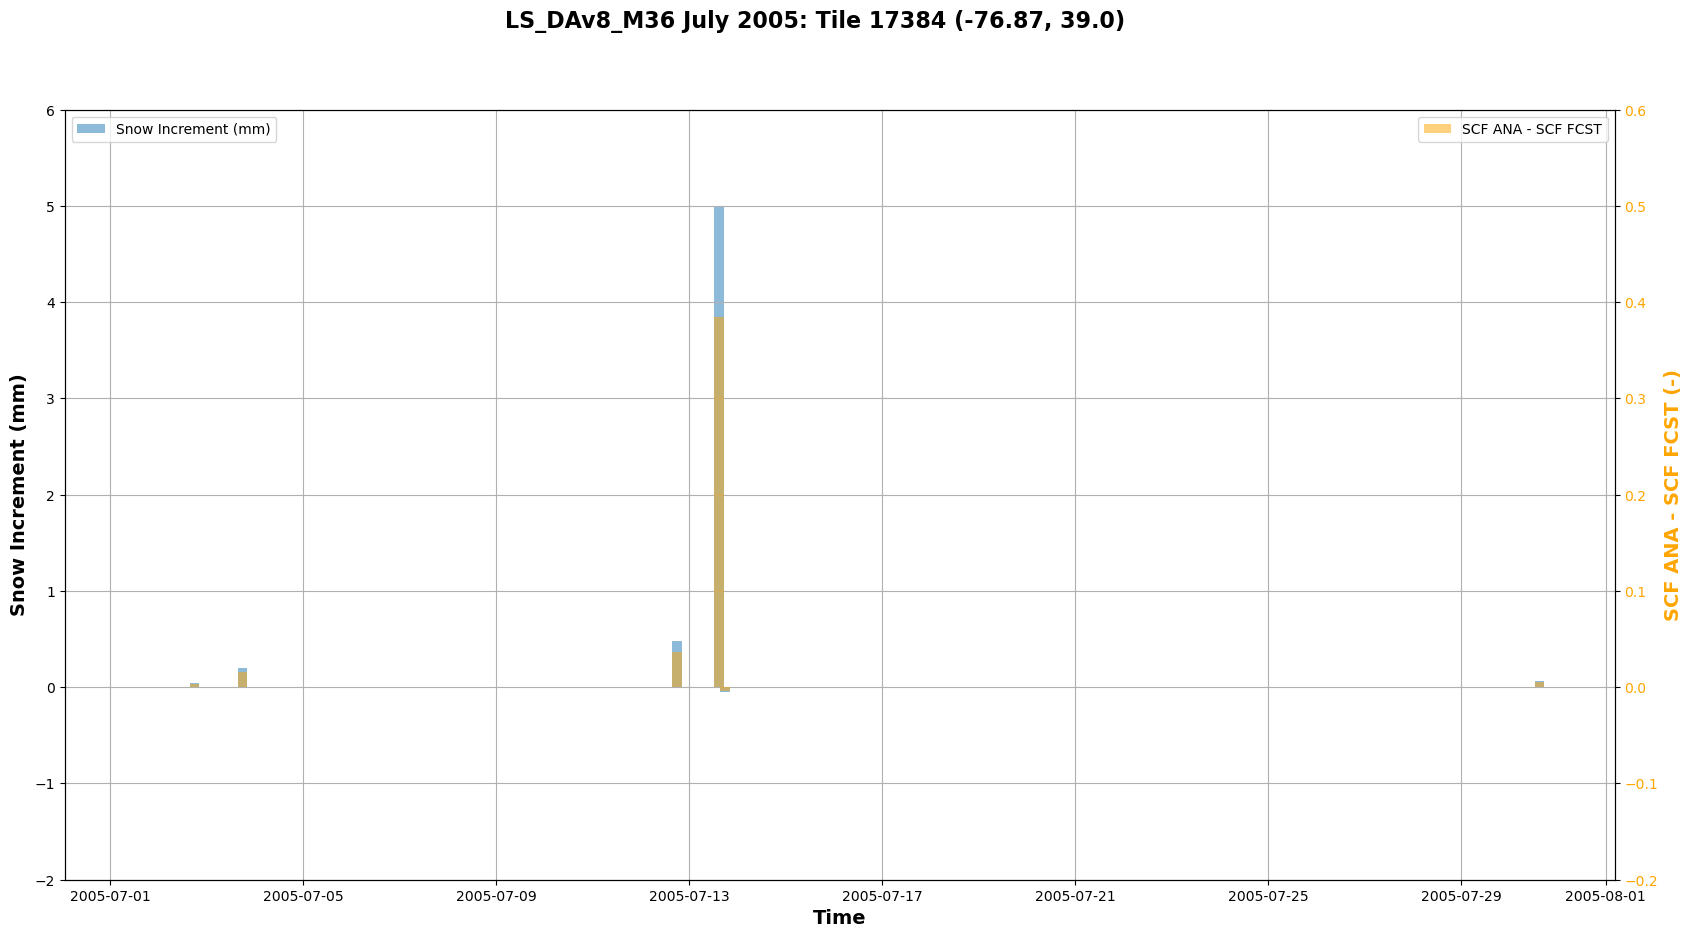

[ 0.          0.00339213  0.          0.01546093  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.03663003  0.38461533 -0.00407228  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.0051282 ]
6
[datetime.datetime(2005, 7, 1, 15, 0) datetime.datetime(2005, 7, 2, 18, 0)
 datetime.datetime(2005, 7, 3, 15, 0) datetime.datetime(2005, 7, 3, 18, 0)
 datetime.datetime(2005, 7, 4, 15, 0) datetime.datetime(2005, 7, 4, 18, 0)
 datetime.datetime(2005, 7, 6, 18, 0) datetime.datetime(2005, 7, 8, 15, 0)
 datetime.datetime(2005, 7, 8, 18, 0) datetime.datetime(2005, 7, 9, 15, 0)
 datetime.datetime(2005, 7, 9, 18, 0)
 datetime.datetime(2005, 7, 10, 15, 0)
 datetime.datetime(2005, 7, 11, 18, 0)
 datetime.date

In [25]:
year_month_directory = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg/Y2005/M07'

# Find the files
files = glob.glob(f"{year_month_directory}/*catch_progn_incr*.nc4")

# Load the data
data = xr.open_mfdataset(files, combine='nested', concat_dim="time")

time = data['time'].values
time_stamp = data['time_stamp']
wesnn1_incr = data['WESNN1_INCR']
wesnn2_incr = data['WESNN2_INCR']
wesnn3_incr = data['WESNN3_INCR']

snow_incr = wesnn1_incr + wesnn2_incr + wesnn3_incr
# Ensure snow_incr is properly defined
if not isinstance(snow_incr, xr.DataArray):
    raise ValueError("snow_incr is not a valid xarray.DataArray")

# Find snow increments that are larger than abs(0.001)
snow_incr = snow_incr.where(np.abs(snow_incr) > 0.001)

# Count and find the mean of the snow increments, ignoring NaNs
snow_incr_count = snow_incr.count(dim='time')
snow_incr_mean = snow_incr.mean(dim='time', skipna=True)  

print(snow_incr_count.values[tile_index])
print(snow_incr_mean.values[tile_index])

time_stamp_values = time_stamp.values

# Parse the byte strings into datetime objects
parsed_timestamps = [
    datetime.strptime(ts.decode('utf-8').rstrip('z'), '%Y%m%d_%H%M') for ts in time_stamp_values
]

# Filter data for July 2005
july_2005_mask = [date.year == 2005 and date.month == 7 for date in dates]
dates_july_2005 = np.array(dates)[july_2005_mask]
ts_obs_july_2005 = ts_obs[july_2005_mask]
ts_fcst_july_2005 = ts_fcst[july_2005_mask]
ts_ana_july_2005 = ts_ana[july_2005_mask]

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot snow_incr on the primary y-axis (bars)
ax1.bar(parsed_timestamps, snow_incr[:, tile_index], width=0.2, alpha=0.5, label='Snow Increment (mm)')
ax1.set_xlabel('Time', weight='bold', fontsize=14)
ax1.set_ylabel('Snow Increment (mm)', weight='bold', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_ylim(-2, 6)  # Set y-axis limits for snow increment
ax1.grid(True)

# Create a secondary y-axis for ts_ana_july_2005 - ts_fcst_july_2005
ax2 = ax1.twinx()
ts_diff = ts_ana_july_2005 - ts_fcst_july_2005  # Compute the difference
# ts_diff = ts_obs_july_2005
ax2.bar(dates_july_2005, ts_diff, label='SCF ANA - SCF FCST', width=0.2, alpha=0.5, color='orange')
ax2.set_ylabel('SCF ANA - SCF FCST (-)', weight='bold', fontsize=14, color='orange')
ax2.set_ylim(-0.2, 0.6)  # Set y-axis limits for SCF difference
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and legend
fig.suptitle(f'{expt_name} July 2005: Tile {tile_index} ({lon_value}, {lat_value})', weight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()
print(ts_diff)
print(np.sum(np.abs(ts_diff) > 0.001))
print(dates_july_2005)


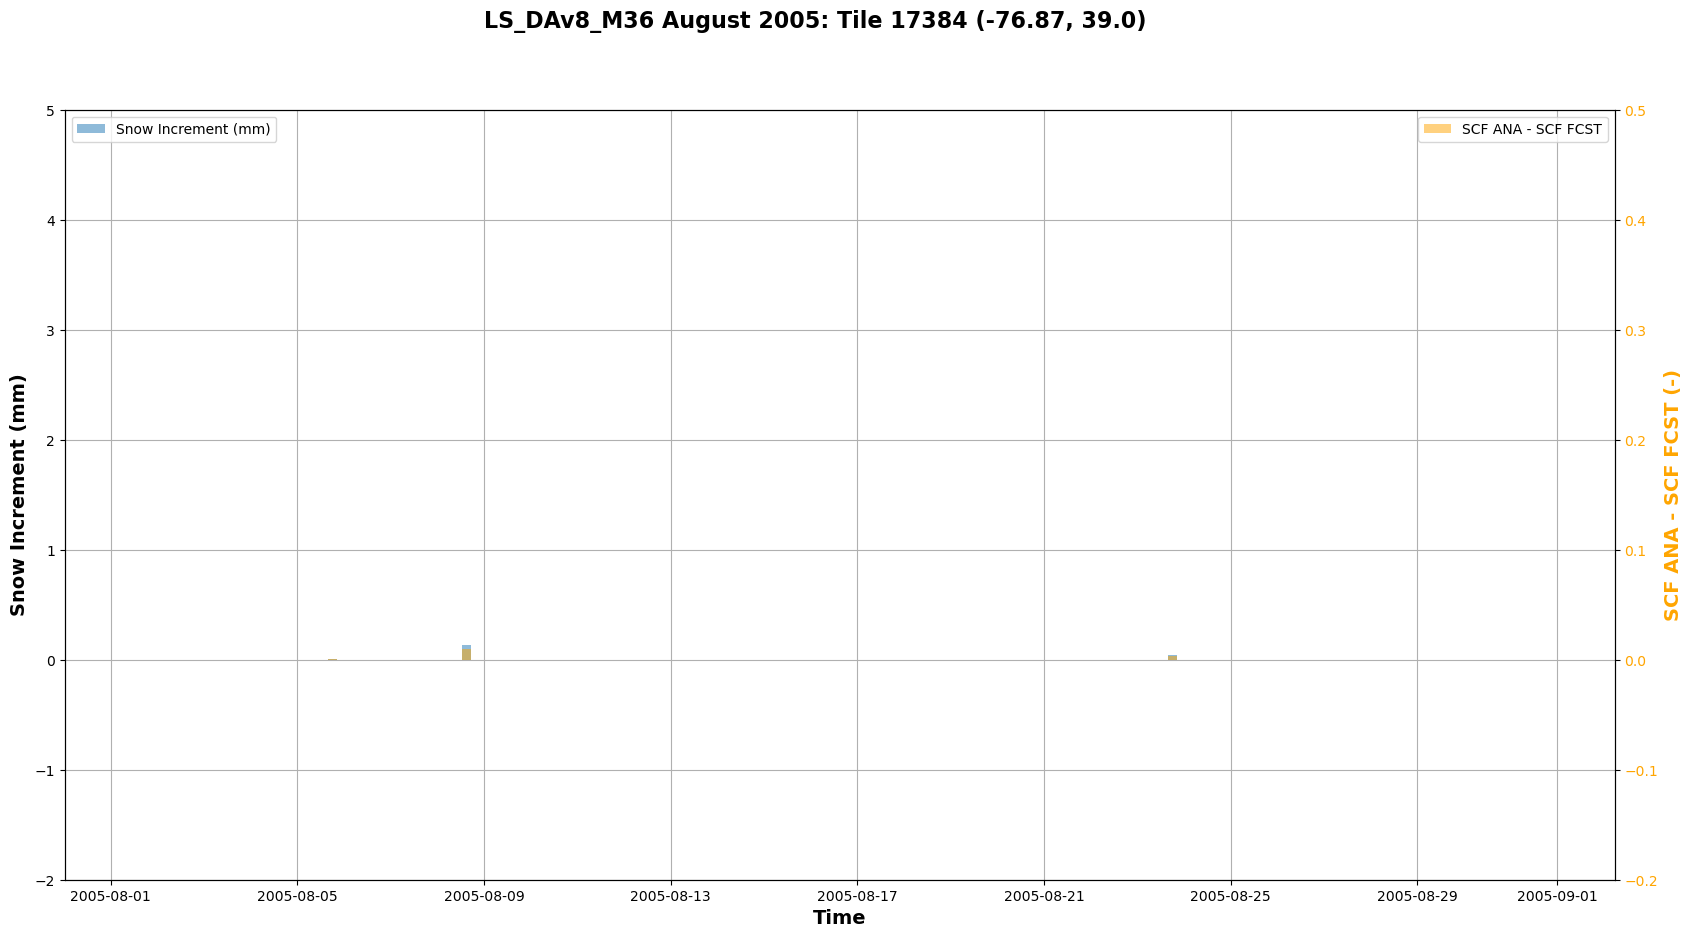

In [26]:
year_month_directory = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg/Y2005/M08'

# Find the files
files = glob.glob(f"{year_month_directory}/*catch_progn_incr*.nc4")

# Load the data
data = xr.open_mfdataset(files, combine='nested', concat_dim="time")

time = data['time'].values
time_stamp = data['time_stamp']
wesnn1_incr = data['WESNN1_INCR']
wesnn2_incr = data['WESNN2_INCR']
wesnn3_incr = data['WESNN3_INCR']

snow_incr = wesnn1_incr + wesnn2_incr + wesnn3_incr
# Ensure snow_incr is properly defined
if not isinstance(snow_incr, xr.DataArray):
    raise ValueError("snow_incr is not a valid xarray.DataArray")

# Find snow increments that are larger than abs(0.001)
snow_incr = snow_incr.where(np.abs(snow_incr) > 0.001)

# Count and find the mean of the snow increments, ignoring NaNs
snow_incr_count = snow_incr.count(dim='time')
snow_incr_mean = snow_incr.mean(dim='time', skipna=True)  

time_stamp_values = time_stamp.values

# Parse the byte strings into datetime objects
parsed_timestamps = [
    datetime.strptime(ts.decode('utf-8').rstrip('z'), '%Y%m%d_%H%M') for ts in time_stamp_values
]

# Filter data for August 2005
august_2005_mask = [date.year == 2005 and date.month == 8 for date in dates]
dates_august_2005 = np.array(dates)[august_2005_mask]
ts_obs_august_2005 = ts_obs[august_2005_mask]
ts_fcst_august_2005 = ts_fcst[august_2005_mask]
ts_ana_august_2005 = ts_ana[august_2005_mask]

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot snow_incr on the primary y-axis (bars)
ax1.bar(parsed_timestamps, snow_incr[:, tile_index], width=0.2, alpha=0.5, label='Snow Increment (mm)')
ax1.set_xlabel('Time', weight='bold', fontsize=14)
ax1.set_ylabel('Snow Increment (mm)', weight='bold', fontsize=14)
ax1.tick_params(axis='y')
ax1.set_ylim(-2, 5)  # Set y-axis limits for snow increment
ax1.grid(True)

# Create a secondary y-axis for ts_ana_august_2005 - ts_fcst_august_2005
ax2 = ax1.twinx()
ts_diff = ts_ana_august_2005 - ts_fcst_august_2005  # Compute the difference
ax2.bar(dates_august_2005, ts_diff, label='SCF ANA - SCF FCST', width=0.2, alpha=0.5, color='orange')
ax2.set_ylabel('SCF ANA - SCF FCST (-)', weight='bold', fontsize=14, color='orange')
ax2.set_ylim(-0.2, 0.5)  # Set y-axis limits for SCF difference
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and legend
fig.suptitle(f'{expt_name} August 2005: Tile {tile_index} ({lon_value}, {lat_value})', weight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [27]:
# Load all the concatenated observations
data = np.load(f'../test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/LS_DAv8_M36_20050101_20060101_obsfcstana_extend_datetime_2005.npz', allow_pickle=True)
# List of all the variables in the file
data.files

['date_time',
 'obs_species',
 'obs_tilenum',
 'obs_lon',
 'obs_lat',
 'obs_obs',
 'obs_fcst',
 'obs_ana']

In [28]:
print(data['date_time'][0])


{'year': array([2005], dtype=int32), 'month': array([1], dtype=int32), 'day': array([11], dtype=int32), 'hour': array([9], dtype=int32), 'min': array([0], dtype=int32), 'sec': array([0], dtype=int32), 'dofyr': array([11], dtype=int32), 'pentad': array([3], dtype=int32)}


In [29]:
from datetime import datetime

def convert_date_dict_to_datetime(date_dict):
    """Convert structured date dictionary to datetime object"""
    return datetime(
        year=date_dict['year'][0],
        month=date_dict['month'][0],
        day=date_dict['day'][0],
        hour=date_dict['hour'][0],
        minute=date_dict['min'][0],
        second=date_dict['sec'][0]
    )

# Usage example
date_time = data['date_time'][0]
dt_obj = convert_date_dict_to_datetime(date_time)
print(dt_obj)  # Will print: 2005-01-11 09:00:00

2005-01-11 09:00:00


In [30]:
def convert_dates_array(date_array):
    """Convert array of date dictionaries to datetime objects"""
    datetime_list = []
    
    # Print data structure for debugging
    print("Data structure:", type(date_array), len(date_array))
    print("First element:", date_array[0])
    
    # Loop through date dictionaries
    for date_dict in date_array:
        dt = datetime(
            year=int(date_dict['year'][0]),
            month=int(date_dict['month'][0]),
            day=int(date_dict['day'][0]),
            hour=int(date_dict['hour'][0]),
            minute=int(date_dict['min'][0]),
            second=int(date_dict['sec'][0])
        )
        datetime_list.append(dt)
    
    return datetime_list

# Convert dates
datetime_array = convert_dates_array(data['date_time'])

# Verify conversion
print(f"First date: {datetime_array[0]}")
print(f"Total dates: {len(datetime_array)}")

Data structure: <class 'numpy.ndarray'> 58347625
First element: {'year': array([2005], dtype=int32), 'month': array([1], dtype=int32), 'day': array([11], dtype=int32), 'hour': array([9], dtype=int32), 'min': array([0], dtype=int32), 'sec': array([0], dtype=int32), 'dofyr': array([11], dtype=int32), 'pentad': array([3], dtype=int32)}
First date: 2005-01-11 09:00:00
Total dates: 58347625


In [31]:
# Parse time information and create datetime objects
dates2 = []
for entry in data['date_time']:
    year = entry['year'][0]
    month = entry['month'][0]
    day = entry['day'][0]
    hour = entry['hour'][0]
    minute = entry['min'][0]
    second = entry['sec'][0]
    dates2.append(datetime(year, month, day, hour, minute, second))

print(dates2[0])

2005-01-11 09:00:00


In [32]:
def filter_july_data(data, datetime_list):
    """Extract July data for all observations"""
    # Convert datetime list to numpy array
    datetime_array = np.array(datetime_list)
    
    # Create mask for July dates
    july_mask = np.array([dt.month == 7 for dt in datetime_array])
    
    # Create filtered dictionary
    july_data = {
        'date_time': datetime_array[july_mask],
        'obs_species': data['obs_species'][july_mask],
        'obs_tilenum': data['obs_tilenum'][july_mask],
        'obs_lon': data['obs_lon'][july_mask],
        'obs_lat': data['obs_lat'][july_mask],
        'obs_obs': data['obs_obs'][july_mask],
        'obs_fcst': data['obs_fcst'][july_mask],
        'obs_ana': data['obs_ana'][july_mask]
    }
    
    # Print summary
    print(f"Total observations: {len(datetime_array)}")
    print(f"July observations: {len(july_data['date_time'])}")
    
    return july_data

# Filter July data
july_data = filter_july_data(data, datetime_array)

Total observations: 58347625
July observations: 5274497


In [33]:
def get_tile_species_stats(july_data):
    """Get maximum observations per tile, split by species"""
    
    # Get unique values
    unique_tiles, tile_first_idx = np.unique(july_data['obs_tilenum'], return_index=True)
    unique_species = np.unique(july_data['obs_species'])
    
    # Get coordinates from first occurrences
    tile_lat = july_data['obs_lat'][tile_first_idx]
    tile_lon = july_data['obs_lon'][tile_first_idx]
    
    # Sort data for efficient processing
    sort_idx = np.argsort(july_data['obs_tilenum'])
    sorted_tiles = july_data['obs_tilenum'][sort_idx]
    sorted_species = july_data['obs_species'][sort_idx]
    sorted_obs = july_data['obs_obs'][sort_idx]
    
    # Initialize results dictionary
    results = {
        'tiles': unique_tiles,
        'lat': tile_lat,
        'lon': tile_lon,
        'species': {species: np.zeros(len(unique_tiles)) for species in unique_species}
    }
    
    # Find split points for tiles
    tile_splits = np.searchsorted(sorted_tiles, unique_tiles)
    tile_splits = np.append(tile_splits, len(sorted_tiles))
    
    # Calculate max obs_obs for each tile and species
    for i in range(len(unique_tiles)):
        tile_data = sorted_obs[tile_splits[i]:tile_splits[i+1]]
        tile_species = sorted_species[tile_splits[i]:tile_splits[i+1]]
        
        for species in unique_species:
            species_mask = tile_species == species
            if np.any(species_mask):
                results['species'][species][i] = np.max(tile_data[species_mask])
    
    return results

# Get statistics
stats = get_tile_species_stats(july_data)

# Print summary
print(f"Number of unique tiles: {len(stats['tiles'])}")
print(f"Number of species: {len(stats['species'])}")
for species, max_vals in stats['species'].items():
    print(f"Species {species}: max value = {np.max(max_vals)}")

Number of unique tiles: 110714
Number of species: 2
Species 12.0: max value = 1.0
Species 13.0: max value = 1.0


In [34]:
print(stats['lat'].shape)
print(stats['lon'].shape)
print(stats['species'][12].shape)

(110714,)
(110714,)
(110714,)


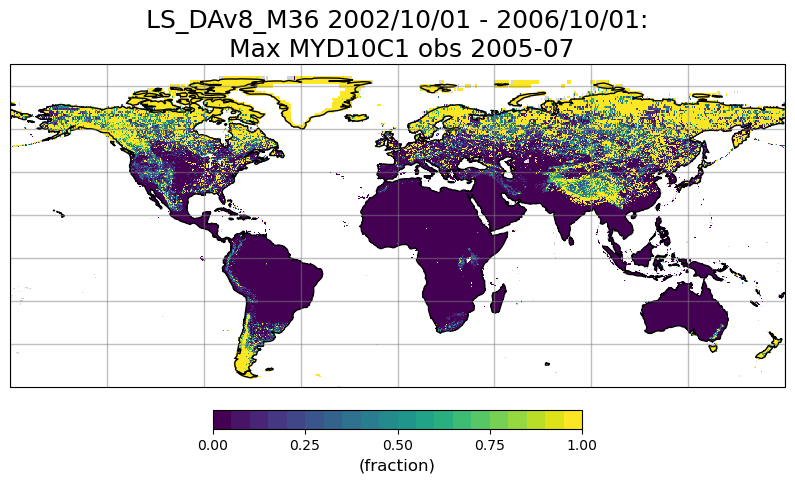

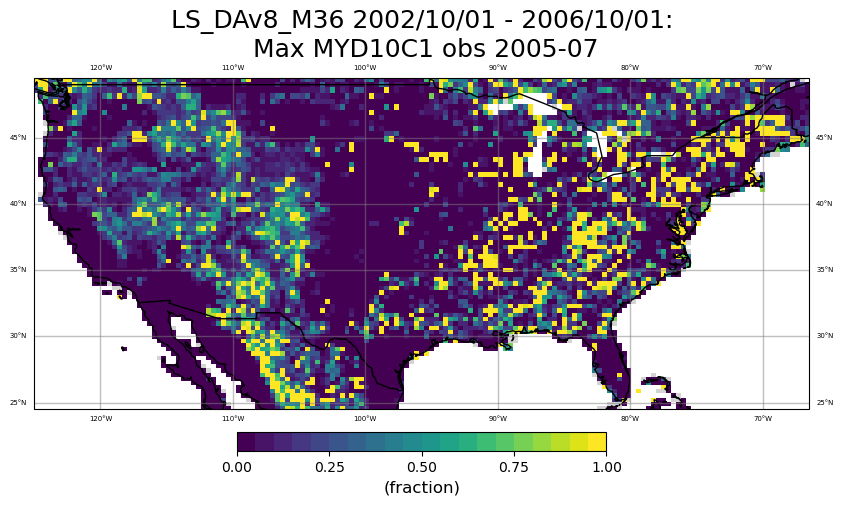

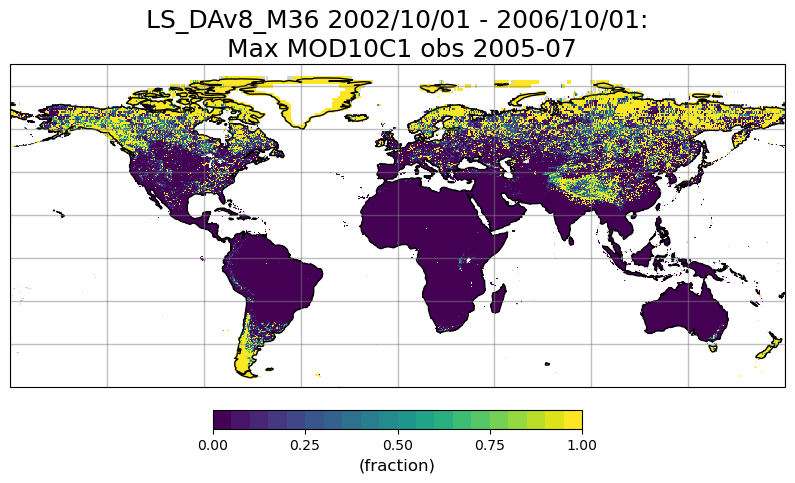

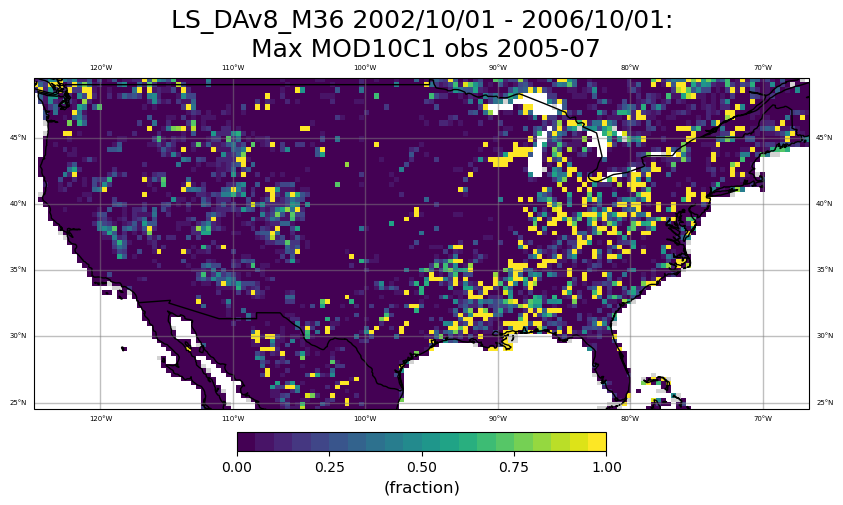

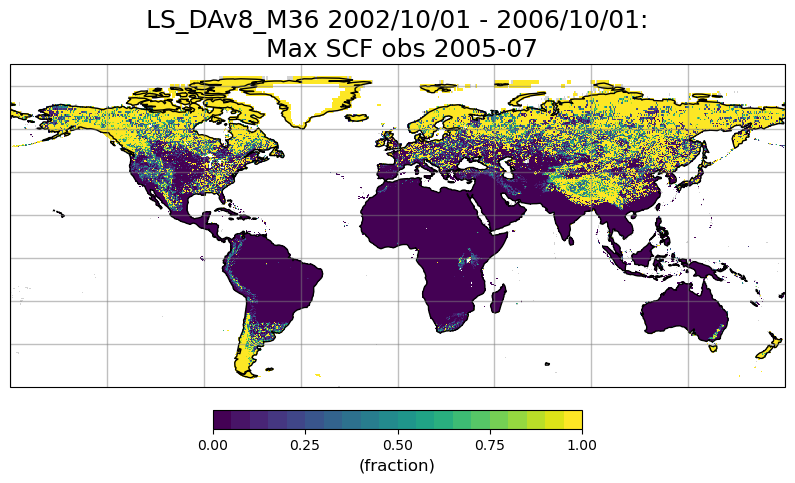

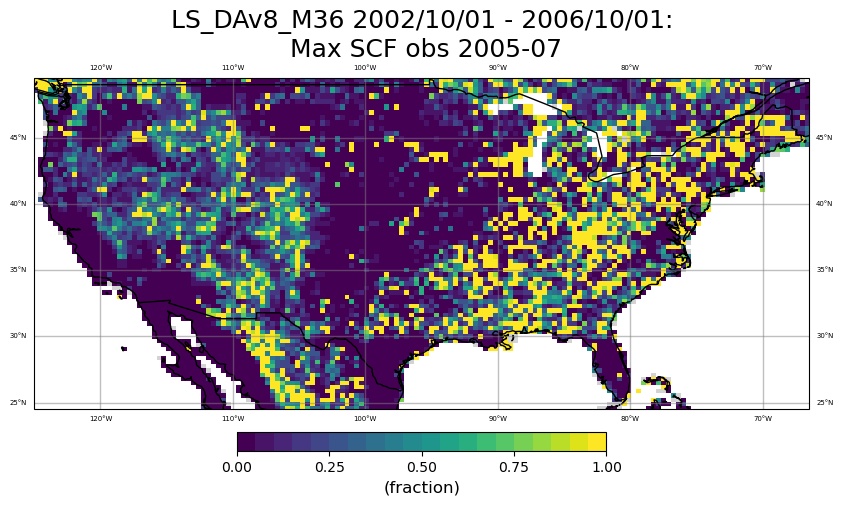

In [35]:
# Initialize map_array with NaN values
map_array = np.empty((stats['lon'].shape[0], 3))  # Shape: (number of tiles, 3)
map_array.fill(np.nan)

# Fill longitude and latitude columns
map_array[:, 1] = stats['lon']  # Assuming `lon` contains longitude values
map_array[:, 2] = stats['lat']  # Assuming `lat` contains latitude values

map_array[:, 0] = stats['species'][12]

plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max MYD10C1 obs 2005-07', 'fraction', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max MYD10C1 obs 2005-07', 'fraction', 0, 1)

map_array[:, 0] = stats['species'][13]

plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max MOD10C1 obs 2005-07', 'fraction', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max MOD10C1 obs 2005-07', 'fraction', 0, 1)

# Create a new array with the higher values from stats['species'][13] or stats['species'][12]
higher_values = np.maximum(stats['species'][13], stats['species'][12])

# Update map_array with the higher values
map_array[:, 0] = higher_values

# Plot the data
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max SCF obs 2005-07', 'fraction', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max SCF obs 2005-07', 'fraction', 0, 1)

In [36]:
from pyhdf.SD import SD, SDC
import numpy as np

def inspect_hdf4_data(filepath):
    """Inspect HDF4 data content and metadata"""
    
    # Open file
    hdf = SD(filepath, SDC.READ)
    
    # Get snow cover dataset
    snow_cover = hdf.select('Day_CMG_Snow_Cover')
    
    # Get metadata
    attrs = snow_cover.attributes()
    
    # Print information
    print("\nDataset Information:")
    print(f"Shape: {snow_cover.info()[2]}")
    print(f"Data type: {snow_cover.info()[3]}")
    
    print("\nAttributes:")
    for key, value in attrs.items():
        print(f"{key}: {value}")
    
    # Get data
    data = snow_cover.get()
    
    print("\nData Statistics:")
    print(f"Min value: {np.min(data)}")
    print(f"Max value: {np.max(data)}")
    print(f"Mean value: {np.mean(data)}")
    
    hdf.end()
    return data, attrs

# Usage
filepath = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/MYD10C1.A2005196.061.hdf"
snow_cover_data, metadata = inspect_hdf4_data(filepath)


Dataset Information:
Shape: [3600, 7200]
Data type: 21

Attributes:
long_name: Daily snow extent, global at 5km 
units: none
coordsys: latitude, longitude
valid_range: [0, 100]
_FillValue: 255
Cell_resolution: 0.05 deg
Water_mask_land_threshold (%): 12.0
Antarctica_snow_note: Antarctica deliberately mapped as snow
Key: 0-100=percent of snow in cell, 107=lake ice, 111=night, 237=inland water, 239=ocean, 250=cloud obscured water, 253=data not mapped, 255=fill

Data Statistics:
Min value: 0
Max value: 255
Mean value: 171.88817445987655


Longitude: [-124.525 -124.525 -124.475 -124.475 -124.475 -124.475 -124.425 -124.425
 -124.425 -124.425]
Latitude: [42.875 42.825 42.925 42.875 42.825 42.775 43.075 43.025 42.975 42.925]
SCF: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


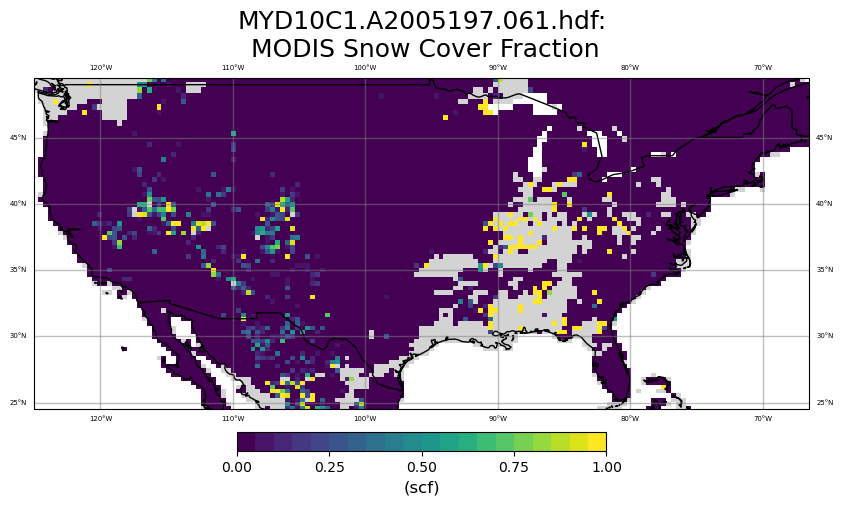

In [37]:
def read_modis_scf_hdf(fname, lon_min, lon_max, lat_min, lat_max):
    """Read MODIS Snow Cover Fraction from HDF4 file."""
    
    # Constants
    CMG_N_lon = 7200
    CMG_N_lat = 3600
    CMG_ll_lon = -180.0
    CMG_ll_lat = -90.0
    CMG_ur_lon = 180.0
    CMG_ur_lat = 90.0
    CMG_dlon = 0.05
    CMG_dlat = 0.05
    
    # QC Parameters
    qc_snow_cover_max = 100
    qc_clear_index_min = 20
    qc_snow_spatial_max = 2
    
    # Calculate array indices for lat/lon bounds
    start_lon = int((lon_min - CMG_ll_lon)/CMG_dlon)
    start_lat = int((CMG_ur_lat - lat_max)/CMG_dlat)
    end_lon = int((lon_max - CMG_ll_lon)/CMG_dlon)
    end_lat = int((CMG_ur_lat - lat_min)/CMG_dlat)
    
    N_lon = end_lon - start_lon + 1
    N_lat = end_lat - start_lat + 1
    
    # Read HDF file
    hdf = SD(fname, SDC.READ)
    
    # Read datasets
    snow_cover = hdf.select('Day_CMG_Snow_Cover')[start_lat:end_lat+1, start_lon:end_lon+1]
    clear_index = hdf.select('Day_CMG_Clear_Index')[start_lat:end_lat+1, start_lon:end_lon+1]
    snow_spatial_qa = hdf.select('Snow_Spatial_QA')[start_lat:end_lat+1, start_lon:end_lon+1]
    
    # Generate lat/lon arrays
    lon_ind = np.arange(N_lon)
    lat_ind = np.arange(N_lat)
    
    lon_c = CMG_ll_lon + 0.5*CMG_dlon + (start_lon + lon_ind)*CMG_dlon
    lat_c = CMG_ur_lat - 0.5*CMG_dlat - (start_lat + lat_ind)*CMG_dlat
    
    # Apply QC and normalize SCF
    valid_mask = ((snow_cover <= qc_snow_cover_max) & 
                 (clear_index > qc_clear_index_min) & 
                 (snow_spatial_qa <= qc_snow_spatial_max))
    
    # Create output arrays
    lon_out = []
    lat_out = []
    scf_out = []
    
    for i in range(N_lon):
        for j in range(N_lat):
            if valid_mask[j,i]:
                scf = float(snow_cover[j,i])/float(clear_index[j,i])
                lon_out.append(lon_c[i])
                lat_out.append(lat_c[j])
                scf_out.append(scf)
    
    hdf.end()
    
    return np.array(lon_out), np.array(lat_out), np.array(scf_out)

# Usage over CONUS
lon_min = -125.0
lon_max = -66.0
lat_min = 24.0
lat_max = 50.0
fname = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/MYD10C1.A2005196.061.hdf"
lon_out, lat_out, scf_out = read_modis_scf_hdf(fname, lon_min, lon_max, lat_min, lat_max)
# Print the first 10 values
print("Longitude:", lon_out[:10])
print("Latitude:", lat_out[:10])
print("SCF:", scf_out[:10])

map_array = np.zeros((len(lon_out), 3))
# Fill in the map_array with the data
map_array[:, 1] = lon_out
map_array[:, 2] = lat_out
# Fill in the first column with the snow cover fraction
map_array[:, 0] = scf_out

# Plot the data
plot_NA_tight_pcm(map_array, False, False, f'MYD10C1.A2005197.061.hdf:\n MODIS Snow Cover Fraction', 'scf', 0, 1)

In [65]:
from datetime import datetime, timedelta

def parse_modis_filename(filename):
    """Parse MODIS filename to get date"""
    # Extract date portion (assume fixed format)
    date_str = filename.split('.A')[1].split('.')[0]
    
    # Split into year and doy
    year = int(date_str[:4])
    doy_base = int(date_str[4:6])  # 19
    i = int(date_str[6:])          # 0-9
    
    # Combine base DOY and i
    doy = doy_base * 10 + i
    
    # Convert to datetime
    date = datetime(year, 1, 1) + timedelta(days=doy-1)
    
    return date

# Example usage
filename = "MOD10C1.A2005212.061.hdf"
date = parse_modis_filename(filename)
print(f"Date: {date.strftime('%Y-%m-%d')}")

Date: 2005-07-31


 Saving figure as MYD10C1_A2005190_061_hdf_MODIS_SCF_2005_07_09.png 



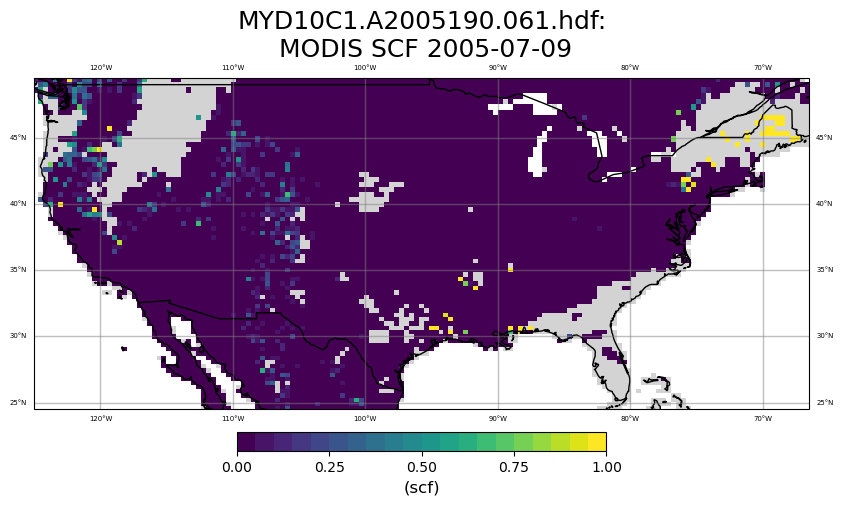

 Saving figure as MYD10C1_A2005191_061_hdf_MODIS_SCF_2005_07_10.png 



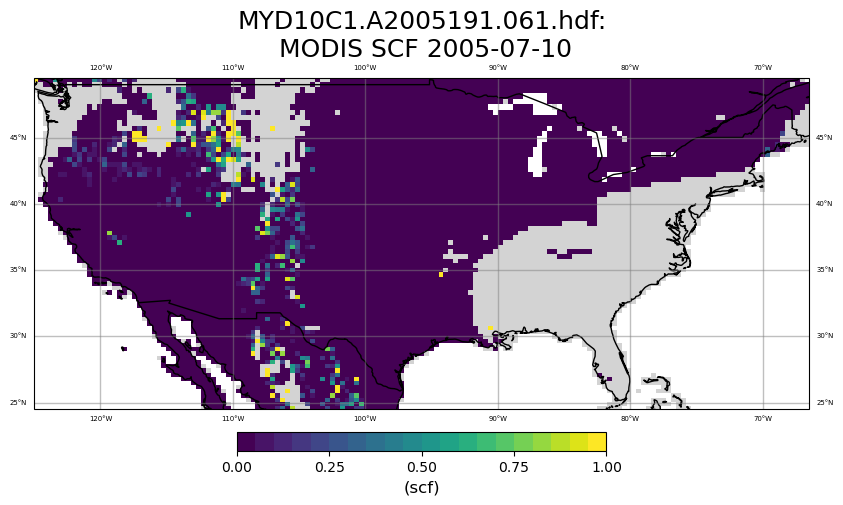

 Saving figure as MYD10C1_A2005192_061_hdf_MODIS_SCF_2005_07_11.png 



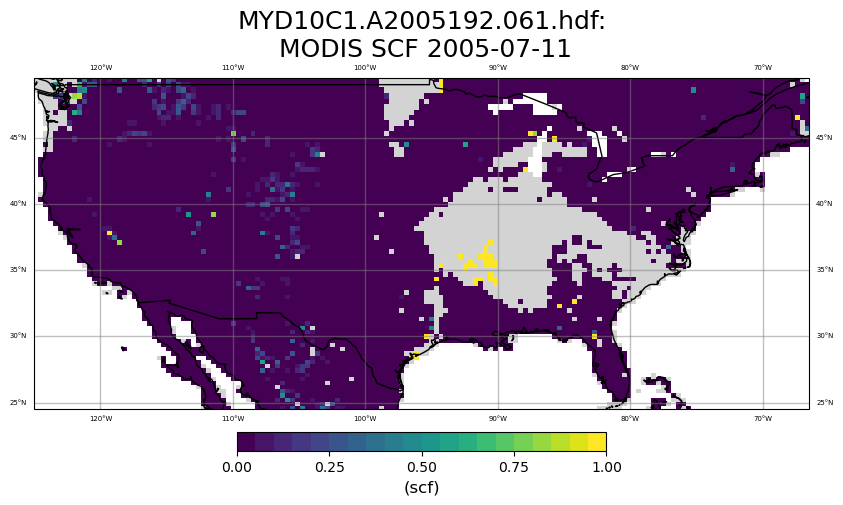

 Saving figure as MYD10C1_A2005193_061_hdf_MODIS_SCF_2005_07_12.png 



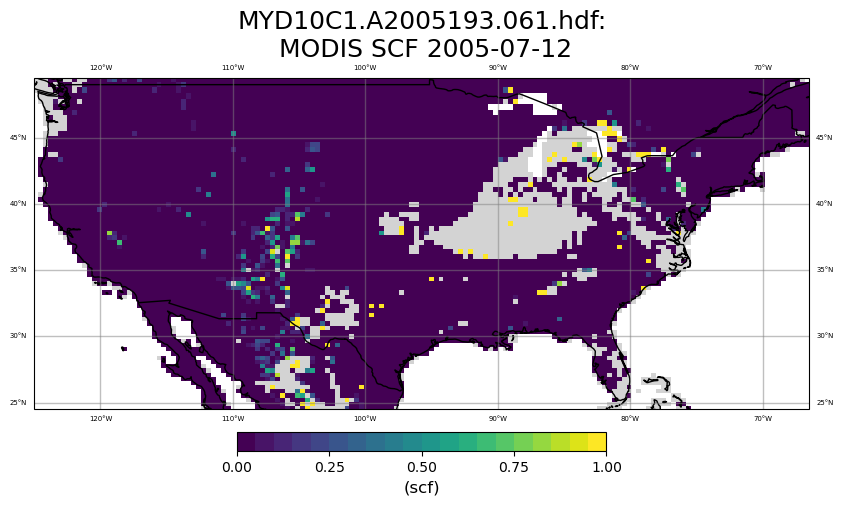

 Saving figure as MYD10C1_A2005194_061_hdf_MODIS_SCF_2005_07_13.png 



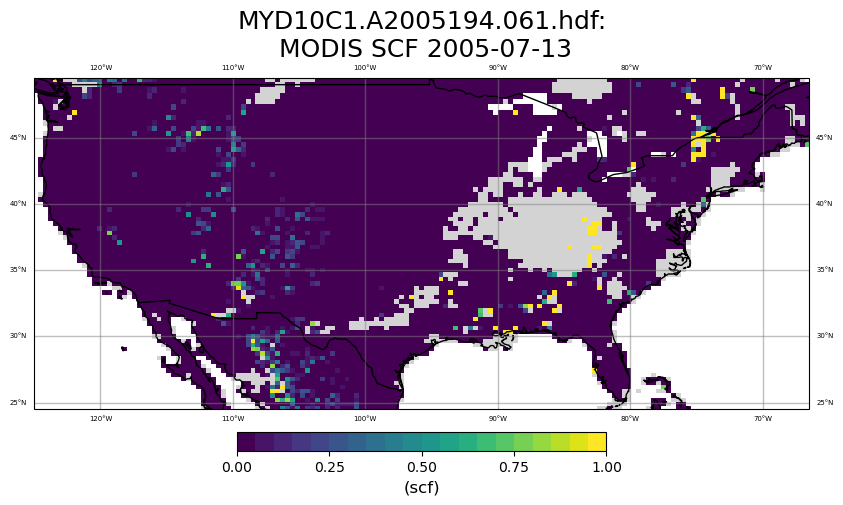

 Saving figure as MYD10C1_A2005195_061_hdf_MODIS_SCF_2005_07_14.png 



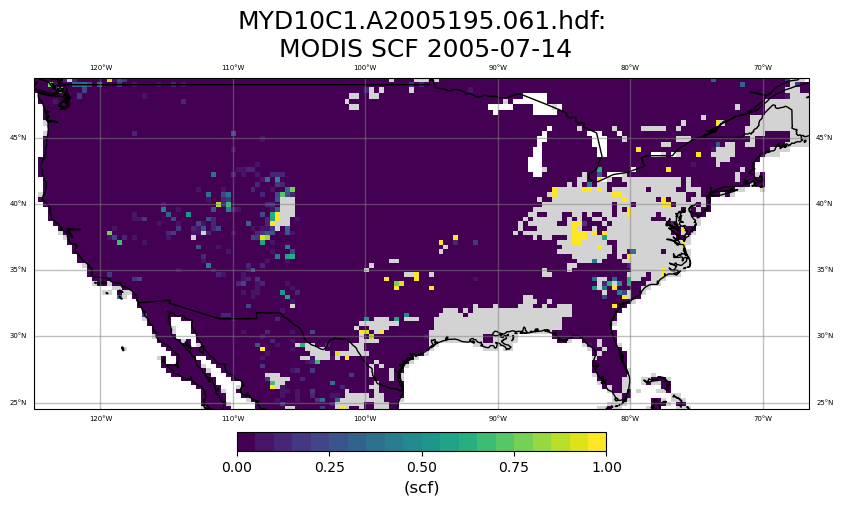

 Saving figure as MYD10C1_A2005196_061_hdf_MODIS_SCF_2005_07_15.png 



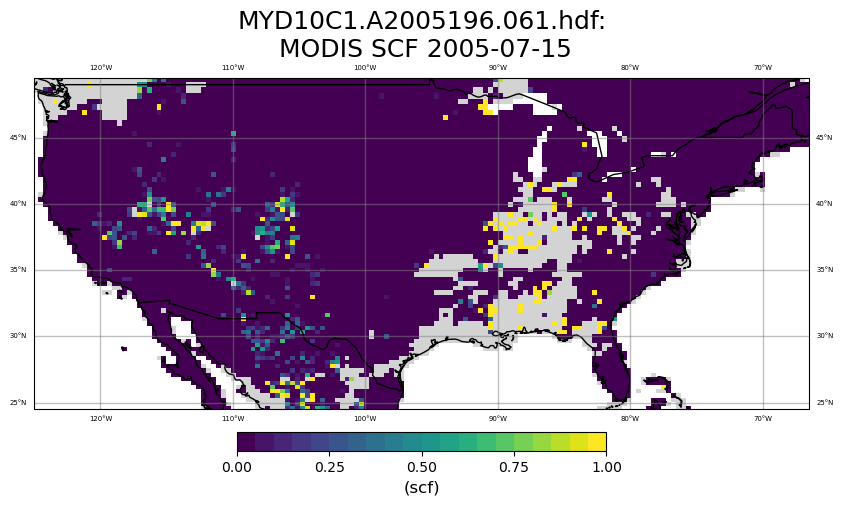

 Saving figure as MYD10C1_A2005197_061_hdf_MODIS_SCF_2005_07_16.png 



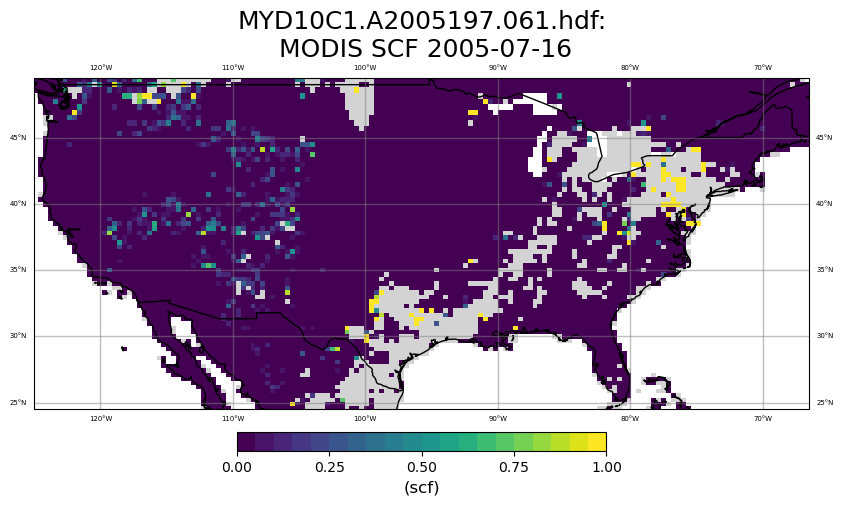

 Saving figure as MYD10C1_A2005198_061_hdf_MODIS_SCF_2005_07_17.png 



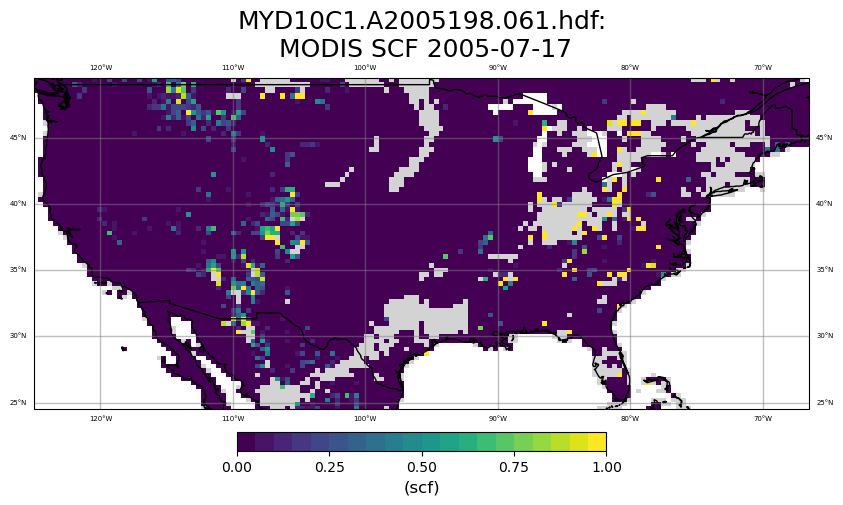

 Saving figure as MYD10C1_A2005199_061_hdf_MODIS_SCF_2005_07_18.png 



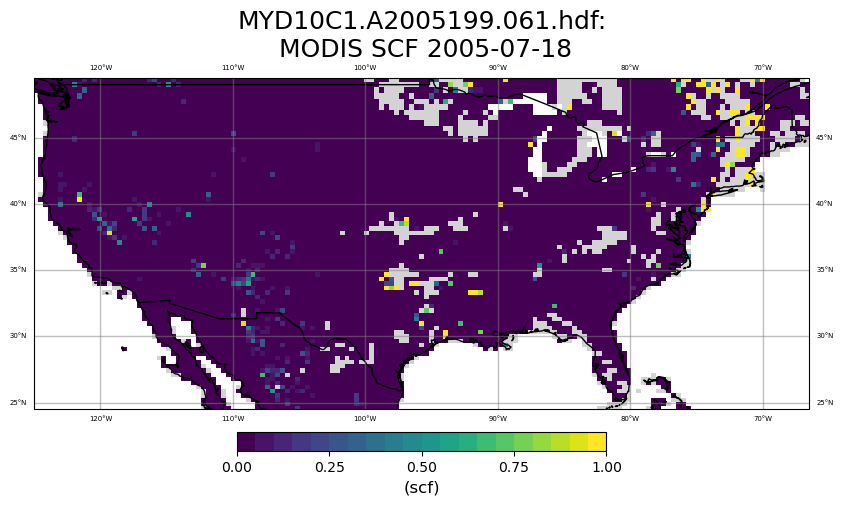

In [50]:
# Usage over CONUS
lon_min = -125.0
lon_max = -66.0
lat_min = 24.0
lat_max = 50.0
path = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/"

for i in range(10):
    fname = f"MYD10C1.A200519{i}.061.hdf"
    path_fname = os.path.join(path, fname)
    date = parse_modis_filename(fname)

    # Read the data
    lon_out, lat_out, scf_out = read_modis_scf_hdf(path_fname, lon_min, lon_max, lat_min, lat_max)
    
    map_array = np.zeros((len(lon_out), 3))
    map_array[:, 1] = lon_out
    map_array[:, 2] = lat_out
    map_array[:, 0] = scf_out
    
    # Plot the data
    plot_NA_tight_pcm(map_array, True, False, f"{fname}:\n MODIS SCF {date.strftime('%Y-%m-%d')}", 'scf', 0, 1)

In [55]:
import imageio
import glob

file_list = sorted(glob.glob("MYD10C1_A200519*_061_hdf_MODIS_SCF_2005_07_*.png"))

with imageio.get_writer('myd10c1_scf_animation.mp4', fps=1) as writer:
    for filename in file_list:
        image = imageio.imread(filename)
        writer.append_data(image)

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/722058914.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (5063, 3039) to (5072, 3040) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x7feb3010de00] Stream #0: not enough frames to estimate rate; consider increasing probesize


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import re
from pathlib import Path

def load_ease_grid(ease_path):
    """Load EASE grid data"""
    lats = np.fromfile(f'{ease_path}/EASE2_M36km.lats.964x406x1.double', 
                      dtype=np.float64).reshape((406,964))
    lons = np.fromfile(f'{ease_path}/EASE2_M36km.lons.964x406x1.double', 
                      dtype=np.float64).reshape((406,964))
    return lats, lons

def create_grid_mapping(array, lats, lons, lats_row, lons_col):
    """Map array data to grid"""
    grid = np.full((lats.shape[0], lons.shape[1]), -9998., dtype=np.float64)
    
    # Map array values to grid
    for i in range(len(array)):
        row = np.abs(lats_row - array[i, 2]).argmin()
        col = np.abs(lons_col - array[i, 1]).argmin()
        if row < grid.shape[0] and col < grid.shape[1]:
            if not np.isnan(array[i, 0]):
                grid[row, col] = array[i, 0]
    
    return grid

def plot_region(array, lon_min, lon_max, lat_min, lat_max, 
                ease_path='../test_data',
                saveflag=False, 
                meanflag=False, 
                plot_title='regional_plot', 
                units='na', 
                cmin=None, 
                cmax=None, 
                cmap=None,
                output_dir='./plots',
                save_fmt='png',
                save_dpi=600,
                star_lon=None,
                star_lat=None):
    """
    Plot data for specified region using EASE grid.
    
    Parameters
    ----------
    array : np.ndarray
        Array of shape (n,3) with values, lons, lats
    lon_min, lon_max : float
        Longitude bounds
    lat_min, lat_max : float
        Latitude bounds
    ease_path : str
        Path to EASE grid files
    """
    # Load EASE grid
    lats, lons = load_ease_grid(ease_path)
    lats_row = lats[:,1]
    lons_col = lons[1,:]
    
    # Create grid mapping
    grid = create_grid_mapping(array, lats, lons, lats_row, lons_col)
    
    # Handle counts/percentages
    if 'Number' in plot_title or 'Percent' in plot_title:
        grid[grid == -9998] = 0
    
    # Calculate statistics
    mean = np.nanmean(array[:, 0])
    std = np.nanstd(array[:, 0])
    textstr = format_stats(mean, std, units, plot_title)
    
    # Set up colormap
    if cmin is None or cmax is None:
        cmin, cmax, cmap = colorbar_info(array)
    if cmap is None:
        cmap = plt.get_cmap('RdBu_r' if cmin < 0 else 'viridis', 20).copy()
    else:
        cmap = plt.get_cmap(cmap)
    cmap.set_under('lightgrey')
    
    # Create plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=0))
    
    # Set region extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    
    # Add map features
    setup_map_features(ax)
    
    # Plot data
    sc = ax.pcolormesh(lons, lats, grid, 
                       transform=ccrs.PlateCarree(), 
                       cmap=cmap, 
                       vmin=cmin, 
                       vmax=cmax)
    
    # Add star if star_lon/lat provided
    if star_lon is not None and star_lat is not None:
        ax.plot(star_lon, star_lat, 'r*', markersize=10, transform=ccrs.PlateCarree())
    
    # Add colorbar and labels
    setup_colorbar(sc, ax, cmin, cmax, units)
    plt.title(plot_title, fontsize=18)
    
    if meanflag:
        ax.text(0.38, 0.05, textstr, fontsize=14, transform=ax.transAxes, ha='left')
    
    if saveflag:
        save_plot(plot_title)
    
    plt.show()
    
    return grid

def format_stats(mean, std, units, plot_title):
    """Format statistics string"""
    if 'Relative $\Delta$ StdDev' in plot_title:
        return f'Mean = {mean:.1f}±{std:.1f} {units}'
    
    def format_number(num):
        if abs(num) < 0.01:
            return f'{num:.4f}'
        elif abs(num) < 1.0:
            return f'{num:.2f}'
        return f'{num:.3g}'
    
    return f'Mean = {format_number(mean)}±{format_number(std)} {units}'

def setup_map_features(ax):
    """Set up map features and gridlines"""
    gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=0), 
                     draw_labels=True,
                     linewidth=1, 
                     color='gray', 
                     alpha=0.5, 
                     linestyle='-')
    gl.xlabel_style = {'size': 5, 'color': 'black'}
    gl.ylabel_style = {'size': 5, 'color': 'black'}
    ax.tick_params(labelbottom=False, labeltop=False, 
                  labelleft=False, labelright=False)
    ax.add_feature(cfeature.LAND, facecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

def setup_colorbar(sc, ax, cmin, cmax, units):
    """Set up colorbar"""
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", 
                       pad=.05, fraction=0.04)
    cbar.set_ticks(np.arange(cmin, cmax+0.000000001, (cmax-cmin)/4))
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(f'({units})', fontsize=12)
 

def save_plot(plot_title, output_dir='./plots', fmt='png', dpi=600):
    """
    Save plot to specified directory
    
    Parameters
    ----------
    plot_title : str
        Title of plot used for filename
    output_dir : str or Path
        Directory to save plots
    fmt : str
        File format (png, pdf, jpg)
    dpi : int
        Resolution for raster formats
    """
    # Create output directory if it doesn't exist
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Clean filename
    clean_title = re.sub('[^0-9a-zA-Z]+', '_', plot_title)
    
    # Construct full save path
    savename = output_path / f"{clean_title}.{fmt}"
    print(f"Saving figure as {savename}")
    
    # Save with specified parameters
    plt.savefig(savename, dpi=dpi, bbox_inches='tight', format=fmt)

def colorbar_info(array):

    # Compute and print some stats for the data
    # -----------------------------------------
    stdev = np.nanstd(array[:,0])  # Standard deviation
    omean = np.nanmean(array[:, 0]) # Mean of the data
    datmi = np.nanmin(array[:, 0])  # Min of the data
    datma = np.nanmax(array[:, 0])  # Max of the data
    abmm = np.nanmax(np.abs(array[:, 0])) # Abs max of the data

    # Min max for colorbar
    # --------------------
    if np.nanmin(array[:, 0]) < 0:
        cmax = abmm
        cmin = abmm * -1
        cmap = 'RdBu'
    else:
        cmax = datma
        cmin = datmi
        cmap = 'viridis'

    return cmin, cmax, cmap    



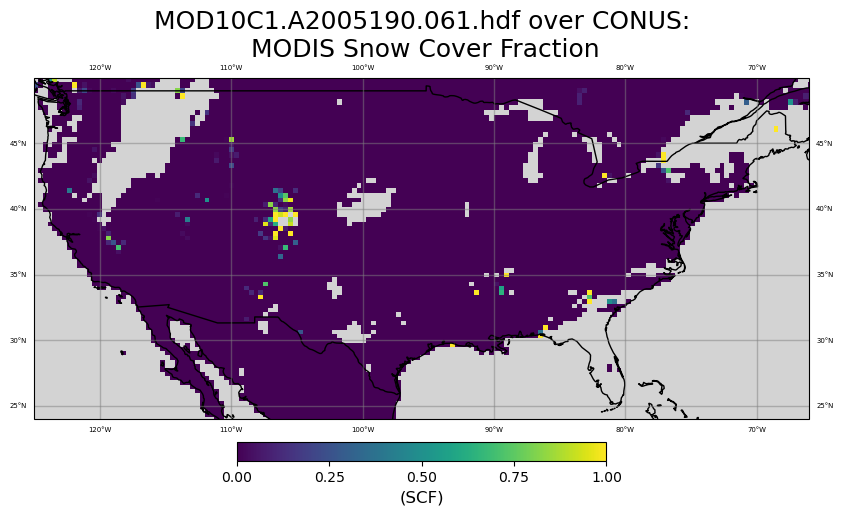

In [42]:
# Usage over CONUS
lon_min = -125.0
lon_max = -66.0
lat_min = 24.0
lat_max = 50.0
path = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/"

for i in range(1):
    fname = f"MOD10C1.A200519{i}.061.hdf"
    path_fname = os.path.join(path, fname)
    
    # Read the data
    lon_out, lat_out, scf_out = read_modis_scf_hdf(path_fname, lon_min, lon_max, lat_min, lat_max)
    
    map_array = np.zeros((len(lon_out), 3))
    map_array[:, 1] = lon_out
    map_array[:, 2] = lat_out
    map_array[:, 0] = scf_out
    
    # Plot the data
    plot_region(map_array, 
           lon_min, lon_max,
           lat_min, lat_max,
           meanflag=False,
           saveflag=False,
           units='SCF',
           plot_title=f'{fname} over CONUS:\n MODIS Snow Cover Fraction')

Saving figure as plots/MYD10C1_A2005190_061_hdf_over_MD_MODIS_SCF_2005_07_09.png


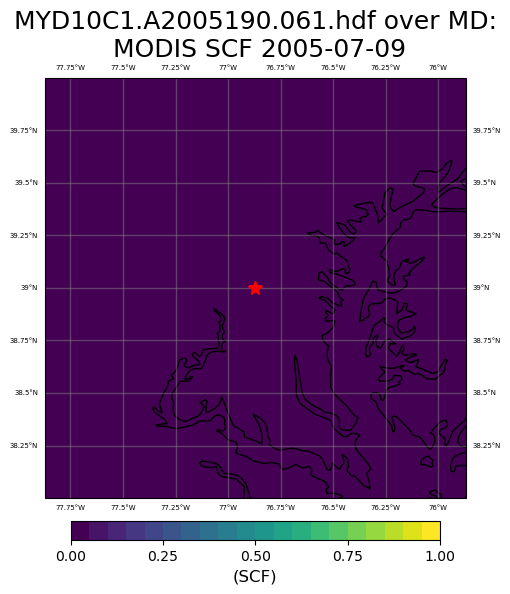

/var/folders/p3/6g36x17x60d12xdgb49ryq4r0000gr/T/ipykernel_24099/4252386137.py:73: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(array[:, 0])
/Users/amfox/opt/anaconda3/envs/xr/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Saving figure as plots/MYD10C1_A2005191_061_hdf_over_MD_MODIS_SCF_2005_07_10.png


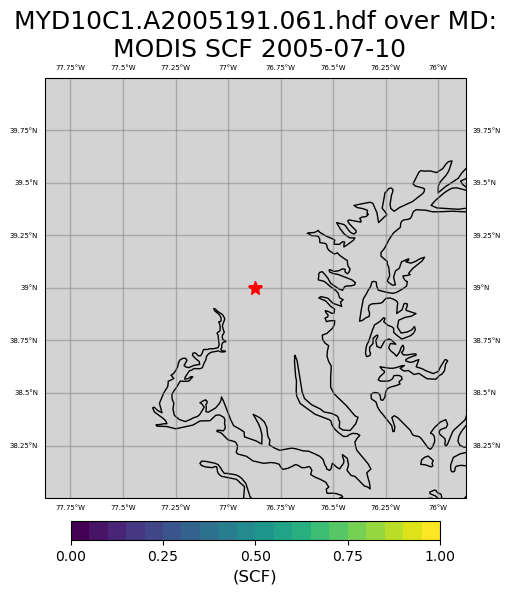

Saving figure as plots/MYD10C1_A2005192_061_hdf_over_MD_MODIS_SCF_2005_07_11.png


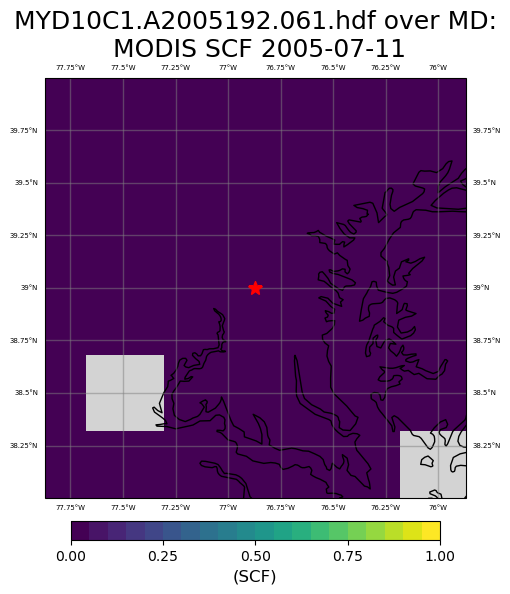

Saving figure as plots/MYD10C1_A2005193_061_hdf_over_MD_MODIS_SCF_2005_07_12.png


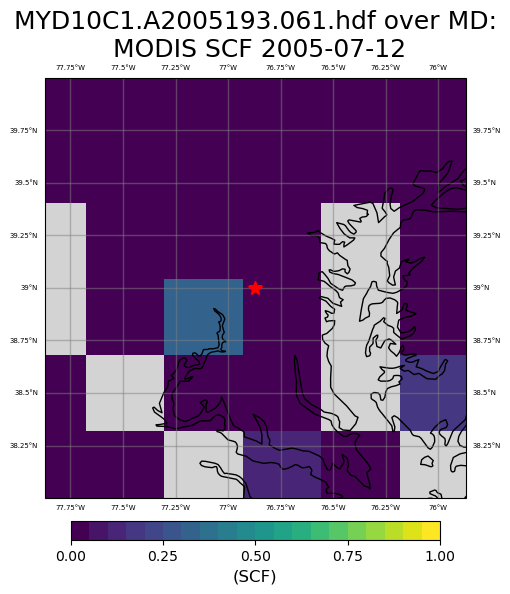

Saving figure as plots/MYD10C1_A2005194_061_hdf_over_MD_MODIS_SCF_2005_07_13.png


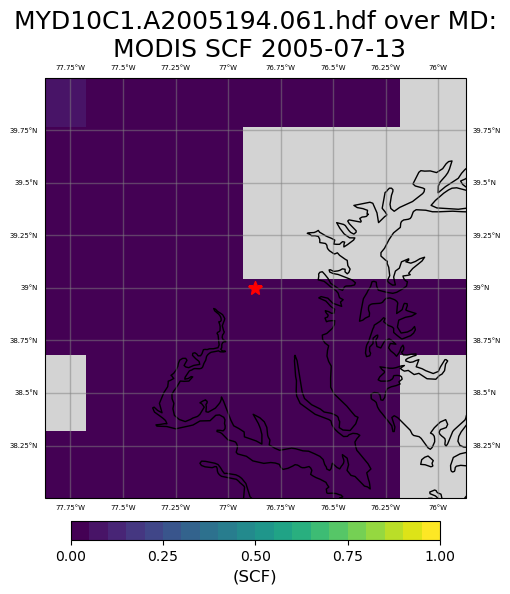

Saving figure as plots/MYD10C1_A2005195_061_hdf_over_MD_MODIS_SCF_2005_07_14.png


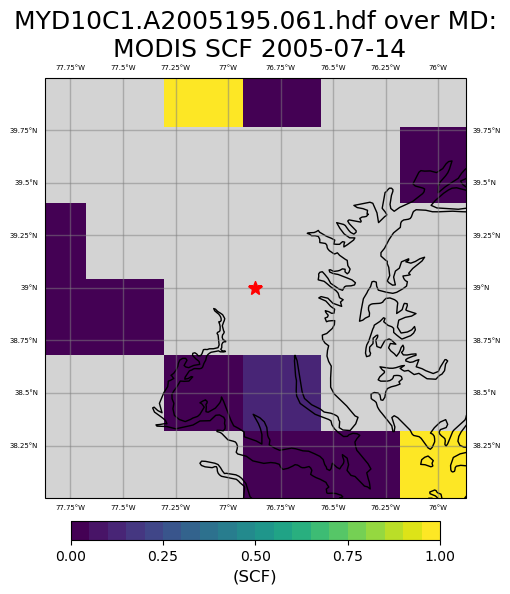

Saving figure as plots/MYD10C1_A2005196_061_hdf_over_MD_MODIS_SCF_2005_07_15.png


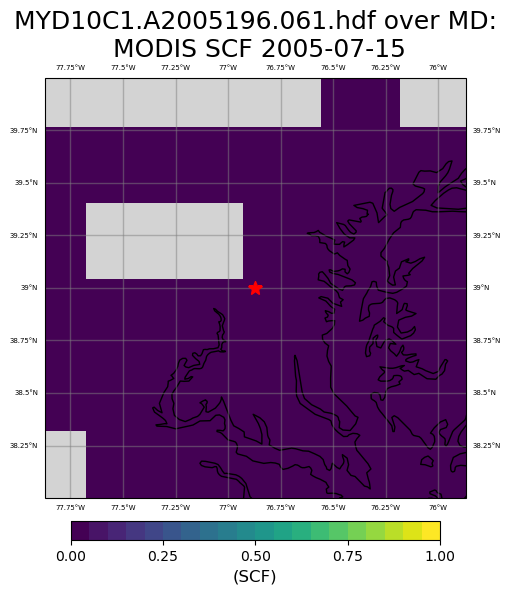

Saving figure as plots/MYD10C1_A2005197_061_hdf_over_MD_MODIS_SCF_2005_07_16.png


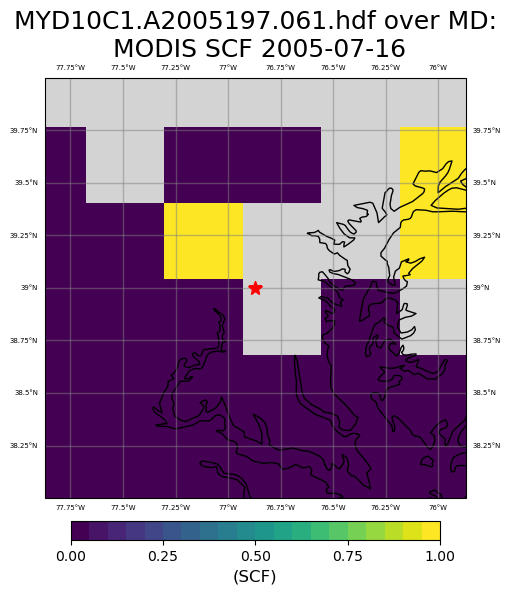

Saving figure as plots/MYD10C1_A2005198_061_hdf_over_MD_MODIS_SCF_2005_07_17.png


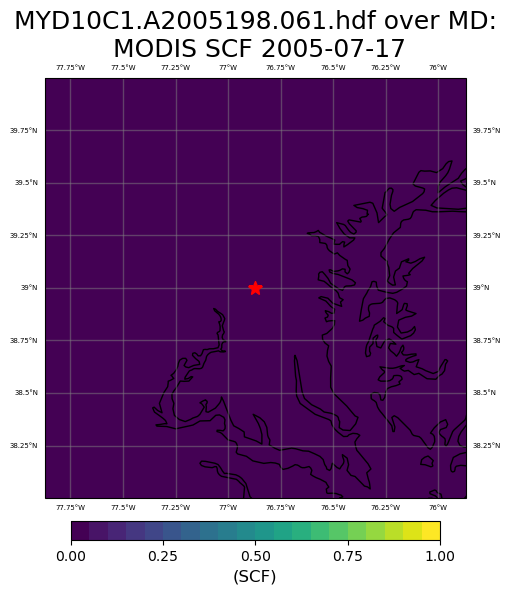

Saving figure as plots/MYD10C1_A2005199_061_hdf_over_MD_MODIS_SCF_2005_07_18.png


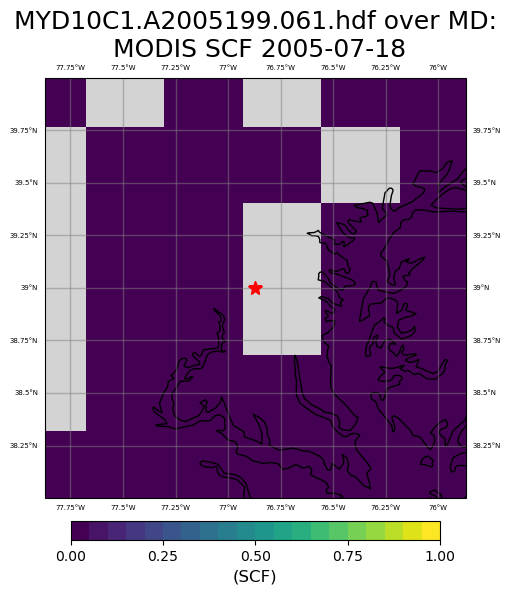

In [56]:
# Usage over Greenbelt
# lon_value = -76.87
# lat_value = 39.0

lon_min = -77.87
lon_max = -75.87
lat_min = 38.0
lat_max = 40.0
path = "/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_OLv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/"

for i in range(10):
    fname = f"MYD10C1.A200519{i}.061.hdf"
    path_fname = os.path.join(path, fname)
    date = parse_modis_filename(fname)
    
    # Read the data
    lon_out, lat_out, scf_out = read_modis_scf_hdf(path_fname, lon_min, lon_max, lat_min, lat_max)
    
    map_array = np.zeros((len(lon_out), 3))
    map_array[:, 1] = lon_out
    map_array[:, 2] = lat_out
    map_array[:, 0] = scf_out
    
    # Plot the data
    plot_region(map_array, 
           lon_min, lon_max,
           lat_min, lat_max,
           meanflag=False,
           saveflag=True,
           units='SCF',
           plot_title=f"{fname} over MD:\n MODIS SCF {date.strftime('%Y-%m-%d')}",
           cmin=0,
           cmax=1,
           star_lon=-76.87,
           star_lat=39.0)

In [61]:
import imageio.v2 as imageio
import glob

file_list = sorted(glob.glob("plots/MYD10C1_A20051*_061_hdf_over_MD_MODIS_SCF_2005_07_*.png"))

with imageio.get_writer('myd10c1_over_MD_scf_animation.mp4', fps=1) as writer:
    for filename in file_list:
        print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)

plots/MYD10C1_A2005190_061_hdf_over_MD_MODIS_SCF_2005_07_09.png


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (3068, 3575) to (3072, 3584) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


plots/MYD10C1_A2005191_061_hdf_over_MD_MODIS_SCF_2005_07_10.png


[rawvideo @ 0x7f7db9716140] Stream #0: not enough frames to estimate rate; consider increasing probesize


plots/MYD10C1_A2005192_061_hdf_over_MD_MODIS_SCF_2005_07_11.png
plots/MYD10C1_A2005193_061_hdf_over_MD_MODIS_SCF_2005_07_12.png
plots/MYD10C1_A2005194_061_hdf_over_MD_MODIS_SCF_2005_07_13.png
plots/MYD10C1_A2005195_061_hdf_over_MD_MODIS_SCF_2005_07_14.png
plots/MYD10C1_A2005196_061_hdf_over_MD_MODIS_SCF_2005_07_15.png
plots/MYD10C1_A2005197_061_hdf_over_MD_MODIS_SCF_2005_07_16.png
plots/MYD10C1_A2005198_061_hdf_over_MD_MODIS_SCF_2005_07_17.png
plots/MYD10C1_A2005199_061_hdf_over_MD_MODIS_SCF_2005_07_18.png


In [ ]:

    
    # Calculate array indices for lat/lon bounds
    start_lon = int((lon_min - CMG_ll_lon)/CMG_dlon)
    start_lat = int((CMG_ur_lat - lat_max)/CMG_dlat)
    end_lon = int((lon_max - CMG_ll_lon)/CMG_dlon)
    end_lat = int((CMG_ur_lat - lat_min)/CMG_dlat)
    
    N_lon = end_lon - start_lon + 1
    N_lat = end_lat - start_lat + 1
    
    # Read HDF file
    hdf = SD(fname, SDC.READ)
    
    # Read datasets
    snow_cover = hdf.select('Day_CMG_Snow_Cover')[start_lat:end_lat+1, start_lon:end_lon+1]
    clear_index = hdf.select('Day_CMG_Clear_Index')[start_lat:end_lat+1, start_lon:end_lon+1]
    snow_spatial_qa = hdf.select('Snow_Spatial_QA')[start_lat:end_lat+1, start_lon:end_lon+1]
    
    # Generate lat/lon arrays
    lon_ind = np.arange(N_lon)
    lat_ind = np.arange(N_lat)
    
    lon_c = CMG_ll_lon + 0.5*CMG_dlon + (start_lon + lon_ind)*CMG_dlon
    lat_c = CMG_ur_lat - 0.5*CMG_dlat - (start_lat + lat_ind)*CMG_dlat





    # QC Parameters
    qc_snow_cover_max = 100
    qc_clear_index_min = 20
    qc_snow_spatial_max = 2
    
    # Apply QC and normalize SCF
    valid_mask = ((snow_cover <= qc_snow_cover_max) & 
                 (clear_index > qc_clear_index_min) & 
                 (snow_spatial_qa <= qc_snow_spatial_max))
    
    # Create output arrays
    lon_out = []
    lat_out = []
    scf_out = []
    
    for i in range(N_lon):
        for j in range(N_lat):
            if valid_mask[j,i]:
                scf = float(snow_cover[j,i])/float(clear_index[j,i])
                lon_out.append(lon_c[i])
                lat_out.append(lat_c[j])
                scf_out.append(scf)
    


    